# Proyecto 4: Clasificación de señales ECG
Intregrantes:

- Laura Esperanza Vargas Patarroyo
- Isabela Trujillo Betancourt

In [ ]:
#Instalaciones

! pip install neurokit2
! pip install PyWavelets
! pip install openpyxl
! pip install statsmodels
! pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.4 MB/s eta 0:00:00


In [ ]:
#Importaciones
import neurokit2 as nk
import matplotlib.pyplot as plt

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt

from google.colab import drive
from operator import length_hint
from ast import Pass

import scipy.stats as sis
import scipy.signal as signal
from scipy.signal import welch as pwelch

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.svm import SVC  # Para clasificación
from sklearn import datasets

from statsmodels.nonparametric.smoothers_lowess import lowess

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

#
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler

## 1. Revisión teórica. Del artículo:
https://www.nature.com/articles/s41598-020-59821-7

Hacer un resumen de la sección extracción de caracteríticas (Features extraction) y discutir desde el artículo u otras referencias como se hace cuando desaparecen ciertas formas de ondas en el complejo PQRS debido a alguna enfermedad (10%)

### Extracción de Características [1]
Los modelos de redes neuronales se han empleado para la clasificación de arritmias, estos modelos utilizaron transformaciones secuenciales de los datos brutos como características que finalmente se introdujeron en un clasificador de regresión logística multinomial (softmax unit).   

Otra estrategia es extraer características como magnitudes de pico, duración, distancias entre picos y su variabilidad en la onda P, onda Q, onda T y complejo QRS. Sin embargo, estas características no son suficientes para una clasificación de alta precisión de diferentes tipos de arritmias, especialmente aquellas se caracterizan por la distorsión u omisión de algunos componentes. Por ejemplo, las ondas P presentes en la fibrilación auricular (AFIB) y en el aleteo auricular (AFL) se reemplazan comúnmente por múltiples ondas de aleteo y fibrilación que son más bajas que una onda P normal en amplitud y no corresponden al ritmo QRS. Adicionalmente, el uso de Wavelet o la Transformada Rápida de Fourier para extraer características de frecuencia hace que se pierda información del dominio del tiempo.   

Por otra parte, uno de los grandes desafíos en la extracción de características es la variabilidad en la morfología de las ondas entre individuos, ya que el ECG varía tanto en amplitud como en frecuencia según el género, edad y raza de la persona. Por esta razón, en el artículo “Optimal Multi-Stage Arrhythmia Classification Approach” reescalan los datos del ECG ates de manipular los datos, para esto emplean el algoritmo de máximo-mínimo para unificar la escala de amplitud y evalúan la influencia del reescalado para la clasificación.
En el artículo mencionado anteriormente, para la comparación de esquemas de clasificación, llevaron a cabo un análisis de los enfoques de selección de las características en 11 escenarios distintos. El primer y más simple conjunto de características solo incluyó 11 características básicas de la señal, mientras que el último y más exhaustivo conjunto incluyó 39.830 características. Adicionalmente, incluyeron la edad y el género como características debido a la importancia que presentan en los análisis médicos. También incluyeron otras características, como la media y la varianza de los intervalos RR, así como los recuentos de este intervalo que solo se calculan en el ECG de derivación II.   

En la tabla 1, se evidencia las características que usaron para cada grupo.   

Tabla 1. Grupo de características [1]
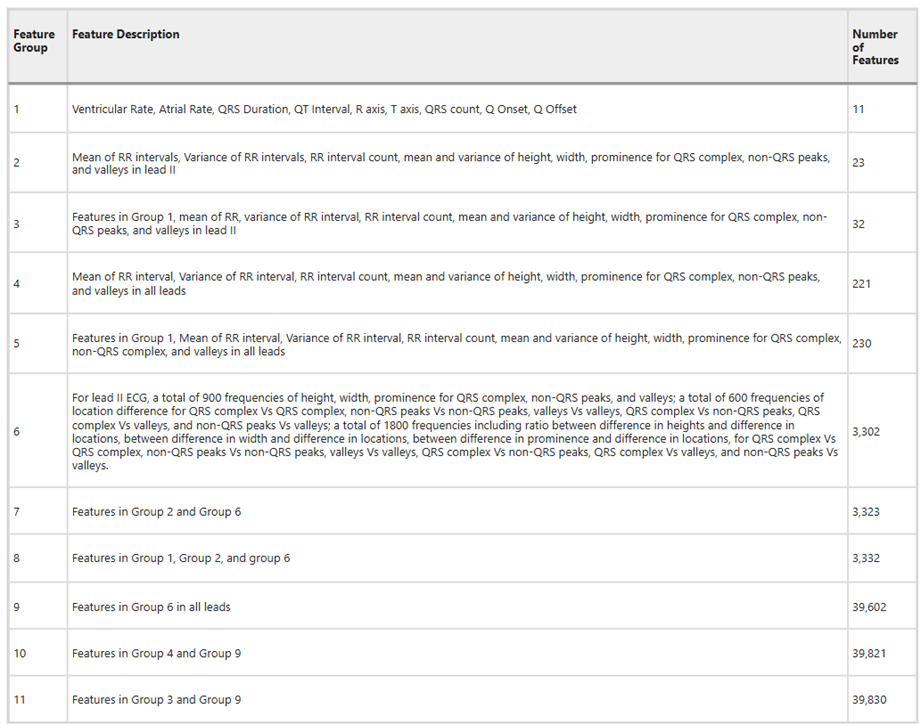   

Adicionalmente, en el artículo los picos y valles representan los máximos y mínimos locales de la señal. La prominencia de un pico o valle mide cuanto se destaca debido a su altura y su ubicación con respecto a los picos o valles vecinos, es decir, que la prominencia es la distancia vertical entre el punto pico y su línea de contorno más baja. Estos picos y valles se asignaron a 3 subconjuntos: complejo QRS, picos no QRS y valles, de modo que la relación entre ellos se midió por medio de 6 combinaciones distintas de pares y para cada combinación calcularon la relación de la diferencia de ancho sobre la diferencia de tiempo, la relación de la diferencia de altura sobre la diferencia de tiempo y la relación de la diferencia de prominencia sobre la diferencia de tiempo. Sin embargo, estas relaciones no se pueden usar como entradas de características para el modo de clasificación, porque cada paciente tendría un número diferente de dichas relaciones, por tal motivo formaron una tabla de distribución de frecuencia empírica que abarca 100 grupos entre el valor máximo y el valor mínimo de las relaciones. Por este motivo, el grupo de características 6 está diseñado para ECG de derivación II.


### Discusión
En algunas enfermedades desaparecen o se distorsionan ciertas formas de onda del complejo PQRS. Por ejemplo, en el caso de la fibrilación auricular, las ondas P se reemplazan por múltiples ondas de aleteo y fibrilación que son más bajas que una onda P normal en amplitud y no corresponden al ritmo QRS [1].    

Para detectar este tipo de enfermedades se puede emplear la duración del ciclo QRS en ms, es decir, su ancho en el eje x [2]. Por otro lado, se puede realizar una detección basada en los intervalos RR y la diferencia entre sus intervalos sucesivos, adicionalmente se comparan los histogramas de densidad estándar de los intervalos RR y sus diferencias [3].


## 2.Base de datos.
 Del proyecto pasado hay dos opciones de base de datos, la filtrada por los autores o la filtrada en el proyecto 3. De acuerdo a los resultados del proyecto 3 usar la mejor base de datos y justificar la selección.

 De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx De estos registros los análisis para el presente proyecto deben hacerse en la derivación II



---


Se utiliza las señales filtradas del proyecto 3 debido a los resultados estadísticos entre los proyectos, donde se obtuvo un valor p en la prueba de U Mann Whitney con las siguientes hipótesis:

H0: No hay diferencia (en términos de tendencia central) entre los dos grupos de la población.
H1: Existe una diferencia (con respecto a la tendencia central) entre los dos grupos de la población

Esta prueba dió como resultado para el proyecto 3 un valor p de 2*10^-79 lo que representa una posibilidad mucho más alta de que las señales de AFIB y SB sean diferentes entre ellas respecto a su tendencia central (es decir rechazar la hipótesis nula). A pesar de que ambos proyectos rechazaban H0, hay mayor diferencia con las señales procesadas del proyecto 3.

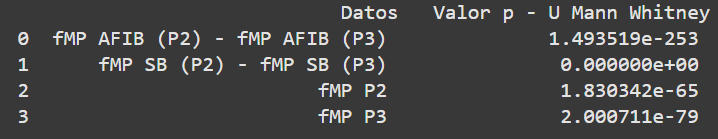

In [ ]:
drive.mount('/content/drive',force_remount=True)
df = pd.read_excel('/content/drive/MyDrive/ColabNotebooks/Biosenales/Diagnostics.xlsx')

AFIB=df[df['Rhythm'] == 'AFIB' ] #Encontrar los nombres de los archivos que corresponden a  la enfermedad Atrial Fibrillation (AFIB)
SB=df[df['Rhythm'] == 'SB' ]  #Encontrar los nombres de los archivos que corresponden a  la enfermedad Sinus Bradycardia (SB)

nombres_AFIB=AFIB['FileName'].tolist() # Forma una lista con lo que esta en FileName del AFIB
nombres_SB=SB['FileName'].tolist()
print(np.shape(nombres_AFIB))
print(np.shape(nombres_SB))

Mounted at /content/drive
(1780,)
(3889,)


In [ ]:
!cp /content/drive/MyDrive/ColabNotebooks/Biosenales/Proyecto_3/ECGData.zip .
!unzip ECGData.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ECGData/MUSE_20180112_133500_45000.csv  
  inflating: ECGData/MUSE_20180112_133502_57000.csv  
  inflating: ECGData/MUSE_20180112_133517_13000.csv  
  inflating: ECGData/MUSE_20180112_133520_30000.csv  
  inflating: ECGData/MUSE_20180112_133525_62000.csv  
  inflating: ECGData/MUSE_20180112_133534_74000.csv  
  inflating: ECGData/MUSE_20180112_133541_12000.csv  
  inflating: ECGData/MUSE_20180112_133542_15000.csv  
  inflating: ECGData/MUSE_20180112_133558_67000.csv  
  inflating: ECGData/MUSE_20180112_133642_18000.csv  
  inflating: ECGData/MUSE_20180112_133714_40000.csv  
  inflating: ECGData/MUSE_20180112_133734_35000.csv  
  inflating: ECGData/MUSE_20180112_133738_64000.csv  
  inflating: ECGData/MUSE_20180112_133746_02000.csv  
  inflating: ECGData/MUSE_20180112_133802_49000.csv  
  inflating: ECGData/MUSE_20180112_133816_89000.csv  
  inflating: ECGData/MUSE_20180112_133822_21000.csv  
  inflating: ECGData/

In [ ]:
directorio_actual=os.getcwd()
archivos=os.listdir(directorio_actual+"/ECGData")

derivacion_AFIB=[]
derivacion_SB=[]

for i in archivos:
  if i[:-4] in nombres_AFIB:
    datos = pd.read_csv(directorio_actual+"/ECGData/"+i,delimiter=',')
    derivacion_AFIB.append(datos['II'])
  if i[:-4] in nombres_SB:
    datos = pd.read_csv(directorio_actual+"/ECGData/"+i,delimiter=',')
    derivacion_SB.append(datos['II'])

In [ ]:
derivacion_AFIB=np.array(derivacion_AFIB)
derivacion_SB=np.array(derivacion_SB)
print(np.shape(derivacion_AFIB))
print(np.shape(derivacion_SB))

(1780, 5000)
(3889, 5000)


### Aplicación del Flujo

In [ ]:
#10 señales para los flujos
datos_AFIB=derivacion_AFIB[:1780,:]
datos_SB=derivacion_SB[:3889,:]

Fs=500 #Según la fuente de la base de datos
n = np.arange(0,10,1/Fs) # tiempo

In [ ]:
def pasa_altas(senal,orden,Fs,rs,fc):
  nyquist = Fs/2 # frecuencia de nyquist
  wn = fc/nyquist #frecuencia de corte normalizada respecto nyquist
  #diseño del filtro
  numerator_h, denominator_h = signal.iirfilter(orden+1,wn,rs=rs, btype = 'highpass',ftype='cheby2')

  #AFIB
  pasa_altas=list()

  for i in senal:
    y_f= signal.filtfilt(b=numerator_h,a=denominator_h,x=i) # aplicación del filtro
    pasa_altas.append(y_f)
  return pasa_altas

In [ ]:
pasa_altas_AFIB=pasa_altas(datos_AFIB,2,Fs,30,0.5)
pasa_altas_SB=pasa_altas(datos_SB,2,Fs,30,0.5)

In [ ]:
#Funciones
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1));
    for i in range(0,len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745; #halla σ
    return stdc;

def threshold(coeff):
    Num_samples = 0;
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0];

    thr = np.sqrt(2*(np.log(Num_samples))) # Halla Lambda
    return thr

def wthresh(coeff):
    y   = list();
    s = wnoisest(coeff);
    #print(s)
    thr = threshold(coeff)
    #print(thr)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i]))); #Aplica el umbral y si es menor lo pone en 0 (umbralización dura)
    return thr,s,y;

In [ ]:
def wavelet_n(senal):
  senal_reconstruida=list()
  for data in senal:
    LL = int(np.floor(np.log2(data.shape[0])));#Halla el nivel

    data_wavelet = pywt.wavedec( data, 'db4', level=8 );

    details = data_wavelet[1:] #Detalles

    thr, s, details_t = wthresh(details);

    # Reconstrucción de la señal filtrada
    coeff = list()
    coeff.append(data_wavelet[0])

    for i in range(len(details_t)):
      coeff.append(details_t[i])

    x_rec = pywt.waverec( coeff, 'db4');
    x_rec = x_rec[0:data.shape[0]];
    senal_reconstruida.append(x_rec)
  return senal_reconstruida

In [ ]:
senal_reconstruida_AFIB=wavelet_n(pasa_altas_AFIB)
senal_reconstruida_SB=wavelet_n(pasa_altas_SB)

In [ ]:
def pasa_bajas_n(senal,orden,Fs,fc):
  nyquist = Fs/2 # frecuencia de nyquist
  wn = fc/nyquist #frecuencia de corte normalizada respecto nyquist
  #numerator_l, denominator_l = signal.iirfilter(orden+1,wn,rs=30, btype = 'lowpass',ftype='cheby2')
  lowpass = signal.firwin(orden+1,wn, pass_zero = 'lowpass',window='boxcar') #filtro
  pasa_bajas=list()
  for i in senal:
    #y_f = signal.filtfilt(b=numerator_l,a=denominator_l,x=i) # aplicación del filtro
    y_f = signal.filtfilt(b=lowpass,a=1,x=i) # aplicación del filtro
    pasa_bajas.append(y_f)
  return pasa_bajas

In [ ]:
pasa_bajas_AFIB_flujo1=pasa_bajas_n(senal_reconstruida_AFIB,6,Fs,50)
pasa_bajas_SB_flujo1=pasa_bajas_n(senal_reconstruida_SB,6,Fs,50)

### Proceso de Normalización

In [ ]:
senales_AFIB_denoised=pasa_bajas_AFIB_flujo1
senales_SB_denoised=pasa_bajas_SB_flujo1

In [ ]:
def detrend_n(senal):
  detrend=[]
  senal= np.nan_to_num(senal, nan=0.0)
  for i in senal:
    A=signal.detrend(i)
    detrend.append(A)

  detrend=np.array(detrend)
  return detrend

In [ ]:
detrend_AFIB=detrend_n(senales_AFIB_denoised)
detrend_SB=detrend_n(senales_SB_denoised)

In [ ]:
def compresion_n(senal):
  n=len(senal)
  x=len(senal[0])
  compresion=np.zeros((n,x))
  fila=0
  for item in senal:
      x_max=max(item)
      x_min=min(item)
      for i,valor in enumerate(item):
        comp=(valor-x_min)/(x_max-x_min)
        compresion[fila, i] = comp
      fila+=1
  fila2=0
  for i in compresion:
    det2=signal.detrend(i) #Como la señal se desfasa para dejarla en el rango de 0 y 1 se vuelve a aplicar detrend para que quede centrada en 0.
    compresion[fila2]=det2
    fila2+=1
  return compresion

In [ ]:
compresion_AFIB=compresion_n(detrend_AFIB)
compresion_SB=compresion_n(detrend_SB)

In [ ]:
# Señales del Proyecto 3
senales_AFIB = compresion_AFIB
senales_SB = compresion_SB

## 3. Herramientas computacionales.
 Hacer un minitutorial del uso de la herramienta NeuroKit (https://neuropsychology.github.io/NeuroKit/index.html) orientado al análisis de señales ECG (10%)


    Anexo

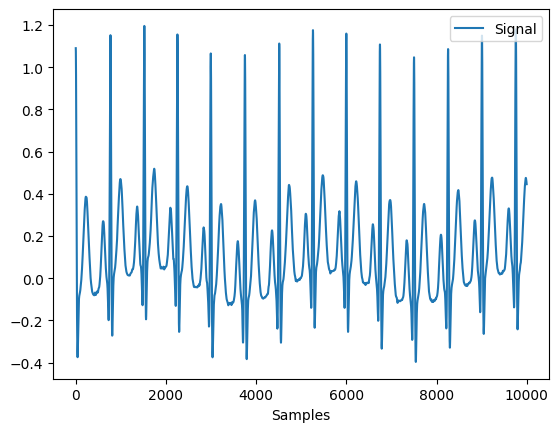

In [ ]:
# Simulación ECG
ecg = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=80)
# Viualizar
nk.signal_plot(ecg)

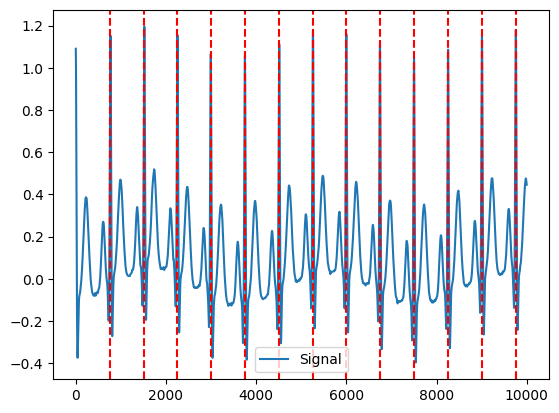

In [ ]:
# Visulización Picos R
_, rpeaks = nk.ecg_peaks(ecg, sampling_rate=1000)
nk.events_plot(rpeaks['ECG_R_Peaks'], ecg)


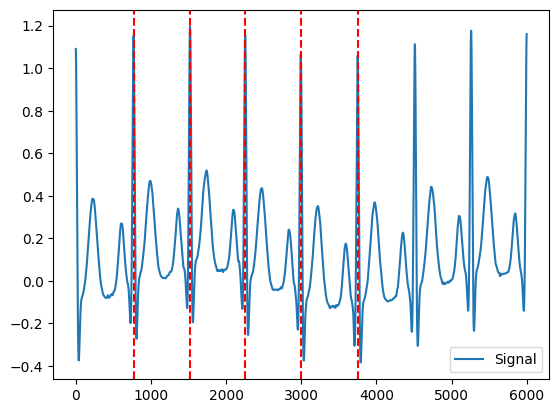

In [ ]:
# Acercamiento de los primeros 5 Picos R
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg[:6000])

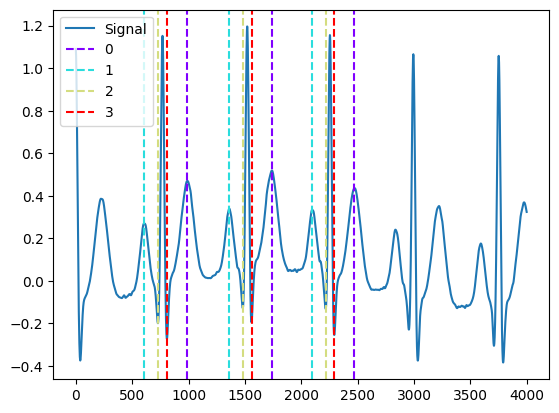

In [ ]:
# Limitar el Ciclo Cardiaco
_, waves_peak = nk.ecg_delineate(ecg, rpeaks, sampling_rate=1000)
# Acercamiento a los picos PQST
nk.events_plot([waves_peak['ECG_T_Peaks'][:3],
                waves_peak['ECG_P_Peaks'][:3],
                waves_peak['ECG_Q_Peaks'][:3],
                waves_peak['ECG_S_Peaks'][:3]],
                ecg[:4000])


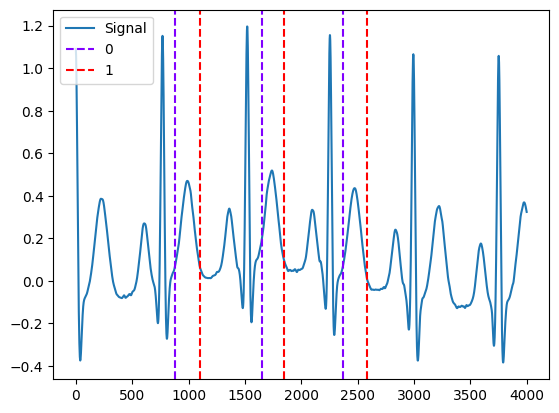

In [ ]:
nk.events_plot([waves_peak["ECG_T_Onsets"][:3], waves_peak["ECG_T_Offsets"][:3]], ecg[:4000])

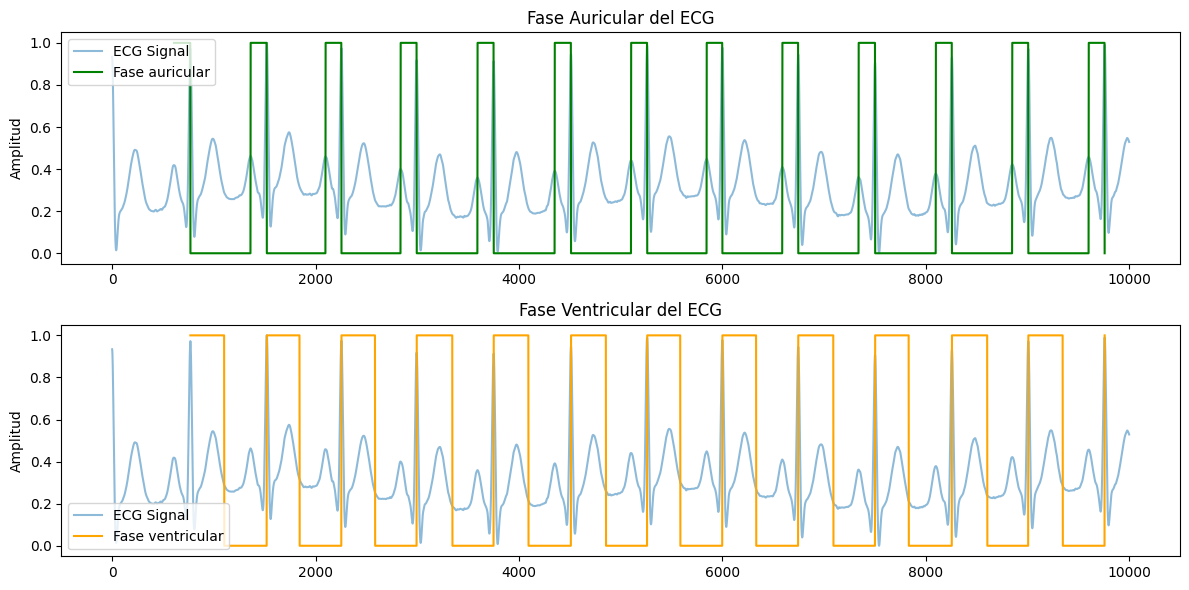

In [ ]:
cardiac_phase = nk.ecg_phase(ecg, rpeaks, delineate_info=waves_peak, sampling_rate=1000)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(nk.rescale(ecg), label="ECG Signal", alpha=0.5) # Normalizar los valores de una señal o un conjunto de datos para que estén dentro de un rango deseado (0 y 1)
plt.plot(cardiac_phase["ECG_Phase_Atrial"], label="Fase auricular", color="green")
plt.title("Fase Auricular del ECG")
plt.ylabel("Amplitud")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(nk.rescale(ecg), label="ECG Signal", alpha=0.5)
plt.plot(cardiac_phase["ECG_Phase_Ventricular"], label="Fase ventricular", color="orange")
plt.title("Fase Ventricular del ECG")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()  # Ajusta el layout para evitar solapamientos
plt.show()


In [ ]:
print(waves_peak['ECG_T_Peaks'])
print(waves_peak['ECG_P_Peaks'])

[990, 1737, 2472, 3218, 3976, 4732, 5478, 6218, 6968, 7724, 8480, 9230, nan]
[608, 1361, 2098, 2836, 3592, 4351, 5102, 5845, 6589, 7339, 8098, 8849, 9601]


## 4. Escoger diferentes señales de la base de datos del punto 2 y aplicar el tutorial del punto 3 (5%).



In [ ]:
print(np.shape(senales_AFIB))
print(np.shape(senales_SB))

(1780, 5000)
(3889, 5000)


In [ ]:
tutorial_AFIB = senales_AFIB[:10,:]
tutorial_SB = senales_SB[:10,:]

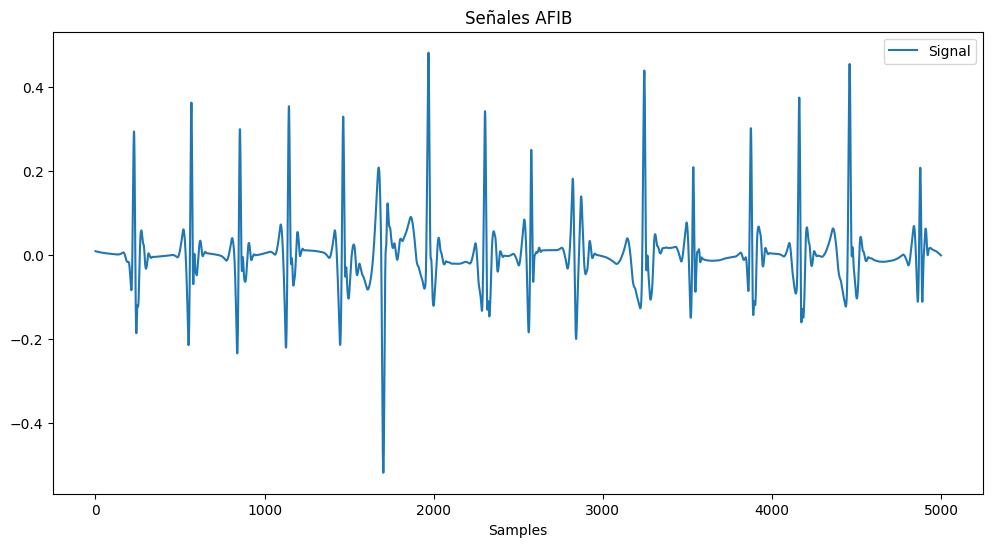

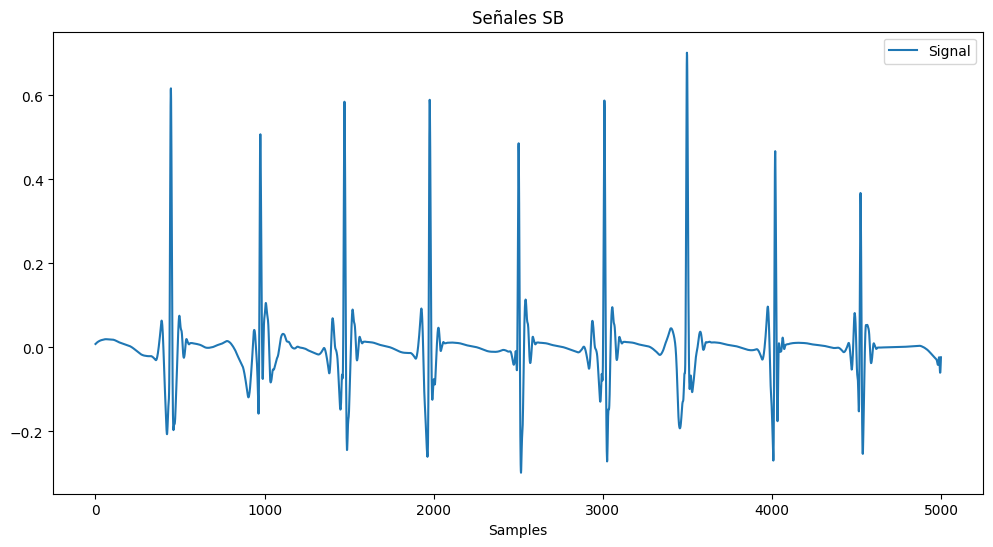

In [ ]:
sujeto=1

nk.signal_plot(tutorial_AFIB[sujeto], title="Señales AFIB", figsize=(12, 6))

nk.signal_plot(tutorial_SB[sujeto], title="Señales SB", figsize=(12, 6))

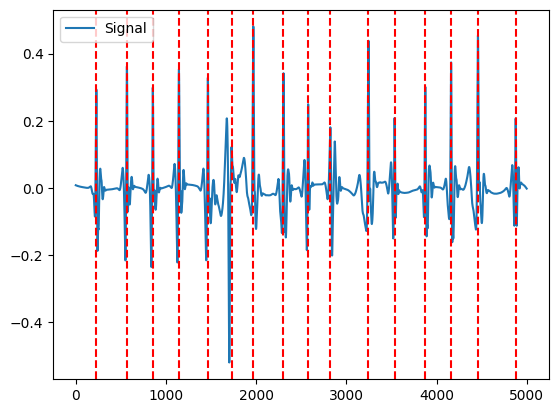

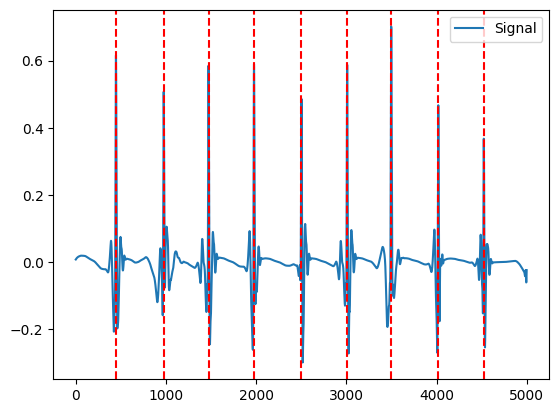

In [ ]:
# Visulización Picos R sujeto con AFIB
_, rpeaks_AFIB = nk.ecg_peaks(tutorial_AFIB[sujeto], sampling_rate=500)
nk.events_plot(rpeaks_AFIB['ECG_R_Peaks'], tutorial_AFIB[sujeto])

# Visulización Picos R sujeto con SB
_, rpeaks_SB = nk.ecg_peaks(tutorial_SB[sujeto], sampling_rate=500)
nk.events_plot(rpeaks_SB['ECG_R_Peaks'], tutorial_SB[sujeto])

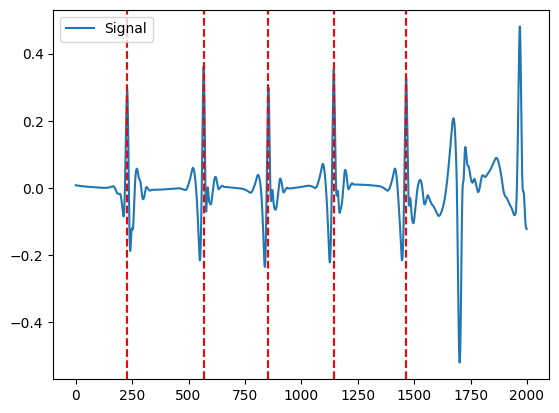

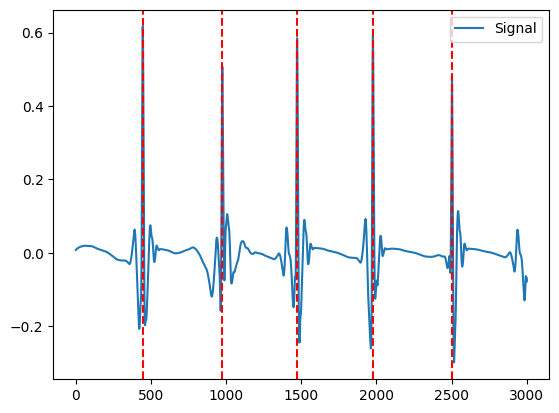

In [ ]:
# Acercamiento de los primeros 5 Picos R, para comprobar que funcione de manera adecuada
plot = nk.events_plot(rpeaks_AFIB['ECG_R_Peaks'][:5], tutorial_AFIB[sujeto][:2000])
plot = nk.events_plot(rpeaks_SB['ECG_R_Peaks'][:5], tutorial_SB[sujeto][:3000])

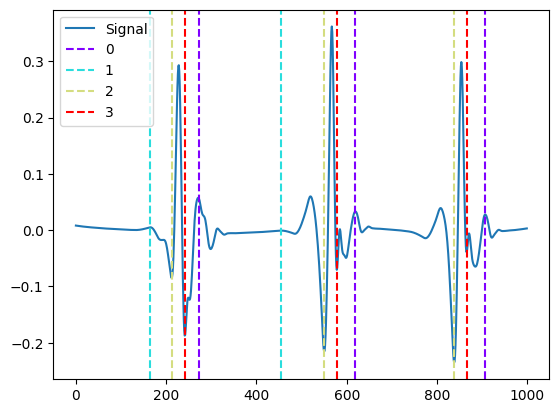

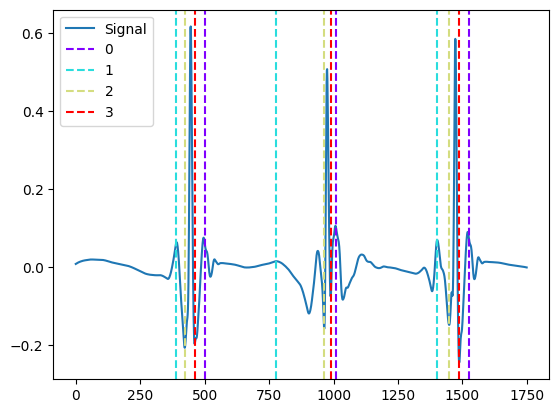

In [ ]:
# Limitar el Ciclo Cardiaco
_, waves_peak_AFIB = nk.ecg_delineate(tutorial_AFIB[sujeto], rpeaks_AFIB, sampling_rate=500)
# Acercamiento a los picos PQST
nk.events_plot([waves_peak_AFIB['ECG_T_Peaks'][:3],
                waves_peak_AFIB['ECG_P_Peaks'][:3],
                waves_peak_AFIB['ECG_Q_Peaks'][:3],
                waves_peak_AFIB['ECG_S_Peaks'][:3]],
                tutorial_AFIB[sujeto][:1000])

_, waves_peak_SB = nk.ecg_delineate(tutorial_SB[sujeto], rpeaks_SB, sampling_rate=500)
# Acercamiento a los picos PQST
nk.events_plot([waves_peak_SB['ECG_T_Peaks'][:3],
                waves_peak_SB['ECG_P_Peaks'][:3],
                waves_peak_SB['ECG_Q_Peaks'][:3],
                waves_peak_SB['ECG_S_Peaks'][:3]],
                tutorial_SB[sujeto][:1750])

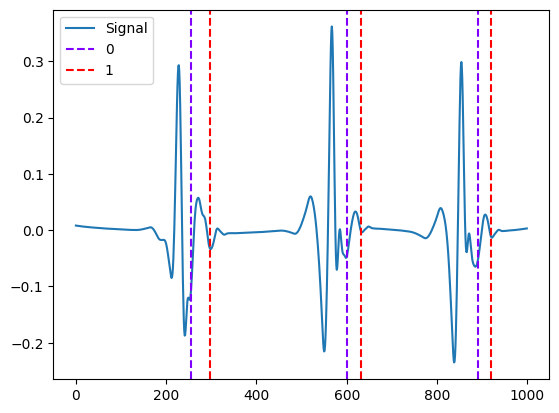

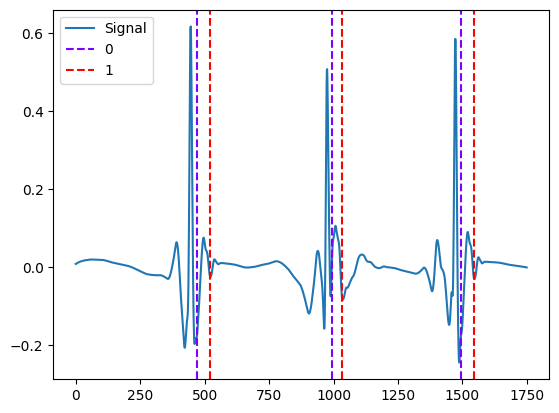

In [ ]:
#Encontrar el onsets y el offsets de la onda T
nk.events_plot([waves_peak_AFIB["ECG_T_Onsets"][:3], waves_peak_AFIB["ECG_T_Offsets"][:3]], tutorial_AFIB[sujeto][:1000])
nk.events_plot([waves_peak_SB["ECG_T_Onsets"][:3], waves_peak_SB["ECG_T_Offsets"][:3]], tutorial_SB[sujeto][:1750])

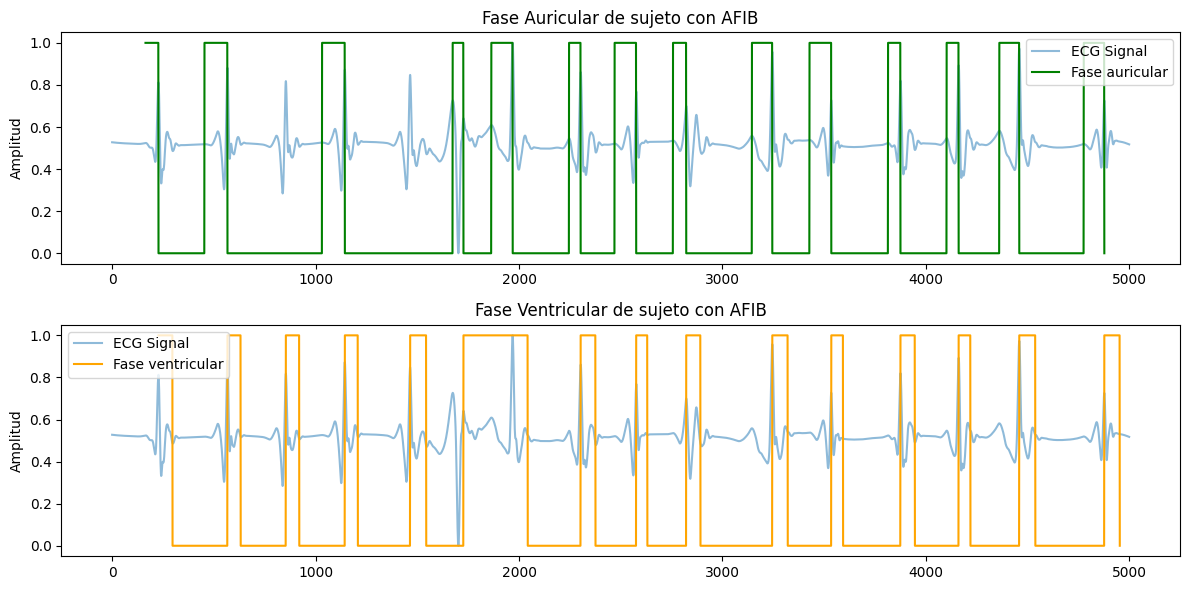

In [ ]:
cardiac_phase_AFIB = nk.ecg_phase(tutorial_AFIB[sujeto], rpeaks_AFIB, delineate_info=waves_peak_AFIB, sampling_rate=500)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(nk.rescale(tutorial_AFIB[sujeto]), label="ECG Signal", alpha=0.5) # Normalizar los valores de una señal o un conjunto de datos para que estén dentro de un rango deseado (0 y 1)
plt.plot(cardiac_phase_AFIB["ECG_Phase_Atrial"], label="Fase auricular", color="green")
plt.title("Fase Auricular de sujeto con AFIB")
plt.ylabel("Amplitud")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(nk.rescale(tutorial_AFIB[sujeto]), label="ECG Signal", alpha=0.5)
plt.plot(cardiac_phase_AFIB["ECG_Phase_Ventricular"], label="Fase ventricular", color="orange")
plt.title("Fase Ventricular de sujeto con AFIB")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()  # Ajusta el layout para evitar solapamientos
plt.show()

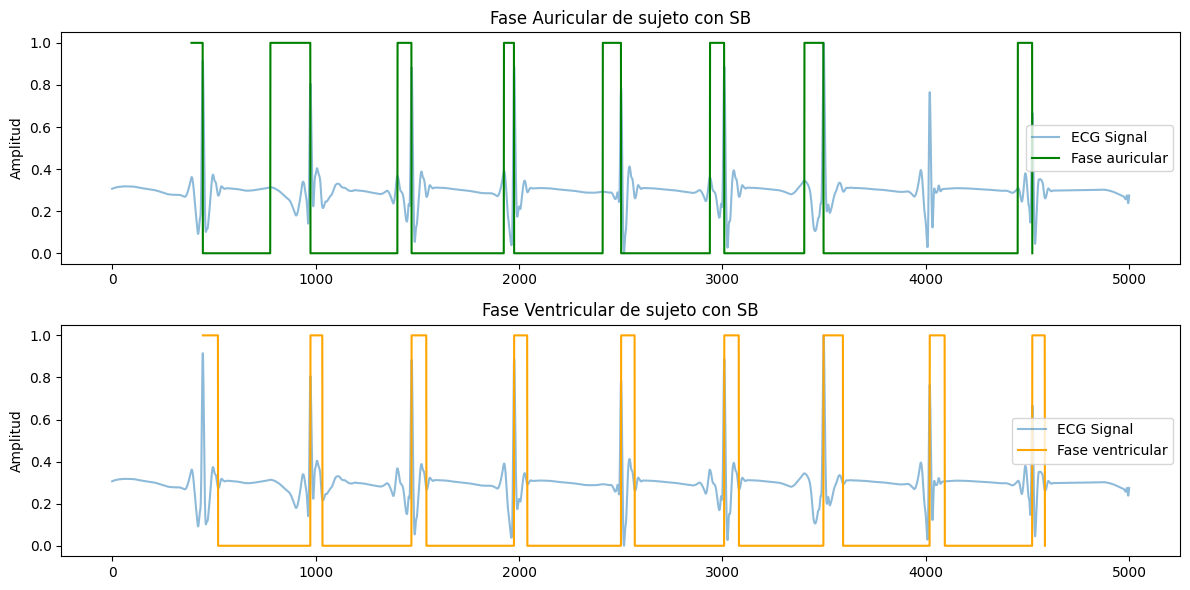

In [ ]:
cardiac_phase_SB = nk.ecg_phase(tutorial_SB[sujeto], rpeaks_SB, delineate_info=waves_peak_SB, sampling_rate=500)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(nk.rescale(tutorial_SB[sujeto]), label="ECG Signal", alpha=0.5) # Normalizar los valores de una señal o un conjunto de datos para que estén dentro de un rango deseado (0 y 1)
plt.plot(cardiac_phase_SB["ECG_Phase_Atrial"], label="Fase auricular", color="green")
plt.title("Fase Auricular de sujeto con SB")
plt.ylabel("Amplitud")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(nk.rescale(tutorial_SB[sujeto]), label="ECG Signal", alpha=0.5)
plt.plot(cardiac_phase_SB["ECG_Phase_Ventricular"], label="Fase ventricular", color="orange")
plt.title("Fase Ventricular de sujeto con SB")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()  # Ajusta el layout para evitar solapamientos
plt.show()

## 5. Con las características que extrae el neurokit y las discutidas en el punto 1 generar un conjunto de características para el presente trabajo.
Incluir la característica de frecuencia de potencia máxima del Proyecto 3 (10%). No incluir más de 15 características ni menos de 5, justificar la selección (5%).


#### Duración Onda T
Al buscar las características necesarias para el entrenamiento de los modelo, se tuvo en cuenta la fisiología de las enfermedades de interés. En el caso de la arritmia AFIB, presenta ondas fibrilatorias (ondas f) u osilaciones mínimas afectando la línea de base entre los complejos QRS por lo que se ve afectada la onda T (debido a que está presente en este intervalo) con las altas frecuencias de las ondas fibrilatorias. Asimismo, altera la duración de esta onda [4].   

In [ ]:
def Duracion_T(senales):
  duracionT=list()

  num_sujetos = len(senales)
  try:
    for sujeto in range(num_sujetos):
      senales[sujeto] = np.nan_to_num(senales[sujeto], nan=np.nanmedian(senales[sujeto]))
      # Complejo QRS sujeto con AFIB
      _, rpeaks = nk.ecg_peaks(senales[sujeto], sampling_rate=Fs)
      # Limitar el Ciclo Cardiaco
      _, waves_peak = nk.ecg_delineate(senales[sujeto], rpeaks, sampling_rate=Fs)

      posicion_Tin = waves_peak['ECG_T_Onsets'] #Posiciones de los picos Q

      posicion_Tf = waves_peak['ECG_T_Offsets'] #Posiciones de los picos T

      # Ajustar las listas para que tengan la misma longitud
      min_len = min(len(posicion_Tf), len(posicion_Tin))
      posicion_Tf = posicion_Tf[:min_len]
      posicion_Tin = posicion_Tin[:min_len]
      posicion_Tf = np.array(posicion_Tf)
      posicion_Tin = np.array(posicion_Tin)

      duracion_T = np.nan_to_num(posicion_Tf, nan=0) - np.nan_to_num(posicion_Tin, nan=0)
      duracion_T = duracion_T[duracion_T >= 0]

      promedio_duracion_T = np.mean(duracion_T) #Promedio de las distancias
      promedio_duracion_T = promedio_duracion_T/Fs

      duracionT.append(promedio_duracion_T)
      #print(f"Duración onda T - Sujeto {sujeto}:", promedio_duracion_T)
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    promedio_duracion_T = np.nan
    duracionT.append(promedio_duracion_T)

  return duracionT

In [ ]:

promedio_duracion_T_AFIB_=Duracion_T(senales_AFIB[:5,:])
# print('Para AFIB')
print(promedio_duracion_T_AFIB_)
promedio_duracion_T_SB_=Duracion_T(senales_SB[:5,:])
# print('Para SB')
print(promedio_duracion_T_SB_)

[0.05146666666666667, 0.062875, 0.05871428571428571, 0.064875, 0.03241666666666666]
[0.15288888888888888, 0.092, 0.0846, 0.11222222222222222, 0.10325]


#### Duración del complejo QRS
Debido a la irregularidad de la frecuenica ventricular de la arritmia AFIB, usualmente la duración del complejo QRS es menor a 120 ms por lo que es una característica a tomar en cuenta para la identificación de esta arritmia [4][5].

In [ ]:
def Duracion_QRS(senales):

  duracionQRS=list()
  num_sujetos = len(senales)
  try:

    for sujeto in range(num_sujetos):
      # Complejo QRS sujeto con AFIB
      _, rpeaks = nk.ecg_peaks(senales[sujeto], sampling_rate=Fs)
      # Limitar el Ciclo Cardiaco
      _, waves_peak = nk.ecg_delineate(senales[sujeto], rpeaks, sampling_rate=Fs)
      posicion_Q = waves_peak['ECG_Q_Peaks'] #Posiciones de los picos Q
      posicion_Q = posicion_Q[:-1] #Elimina el nan de la última posición

      posicion_S = waves_peak['ECG_S_Peaks'] #Posiciones de los picos S
      posicion_S = posicion_S[:-1] #Elimina el nan de la última posición

      distancia_QS = [b - a for a, b in zip(posicion_Q, posicion_S)]
      promedio_distancia_QS= np.mean(distancia_QS) #Promedio de las distancias
      promedio_distancia_QS = promedio_distancia_QS/Fs

      duracionQRS.append(promedio_distancia_QS)
      #print(f"Duración del complejo QRS - Sujeto {sujeto}:", promedio_distancia_QS)
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    promedio_distancia_QS = np.nan
    duracionQRS.append(promedio_distancia_QS)
  return duracionQRS

In [ ]:
print('Para AFIB')
promedio_distancia_QS_AFIB=Duracion_QRS(senales_AFIB[:5,:])
print('Para SB')
promedio_distancia_QS_SB=Duracion_QRS(senales_SB[:5,:])

Para AFIB
Para SB


#### Tiempo entre las ondas P (intervalos PP)
Para la AFIB puede presentarse la desaparición de picos P [5], mientras que para SB se da naturalmente antes del complejo QRS y presenta una frecuencia constante [6].

In [ ]:
def Tiempo_entre_P(senales):
  tiempoP=list()
  num_sujetos = len(senales)
  try:
    for sujeto in range(num_sujetos):
      # Complejo QRS sujeto con AFIB
      _, rpeaks = nk.ecg_peaks(senales[sujeto], sampling_rate=Fs)
      # Limitar el Ciclo Cardiaco
      _, waves_peak = nk.ecg_delineate(senales[sujeto], rpeaks, sampling_rate=Fs)
      posicion_P = waves_peak['ECG_P_Peaks'] #Posiciones de los picos P
      distancia_P = np.diff(posicion_P) #Distancia entre los picos P
      distancia_P = distancia_P[~np.isnan(distancia_P)] #Ignorar los valores que dan nan
      promedio_distancia_P  = np.mean(distancia_P ) #Promedio de las distancias
      promedio_distancia_P = promedio_distancia_P/Fs

      tiempoP.append(promedio_distancia_P)
      #print(f"Tiempo entre las ondas P -Sujeto {sujeto}:", promedio_distancia_P )
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    promedio_distancia_P = np.nan
    tiempoP.append(promedio_distancia_P)
  return tiempoP

In [ ]:

promedio_distancia_P_AFIB=Tiempo_entre_P(senales_AFIB[:5,:])
print(f'AFIB \n{promedio_distancia_P_AFIB}')
print('SB')
promedio_distancia_P_SB=Tiempo_entre_P(senales_SB[:5,:])


AFIB
SB


#### Duración QT
Para una persona sana la observación de que el intervalo QT suele medir menos de la mitad del intervalo RR. Sin embargo esta característica se ve afectada en las arritmias, para la AFIB se puede ver afectada la duración de la duración entre el pico Q y el T por las ondas f mientras que para SB sebe tener frecuencia constante pero más lenta que la de un sujeto sano[4].

In [ ]:
def Duracion_QT(senales):
  duracionQT=list()
  num_sujetos = len(senales)
  try:
    for sujeto in range(num_sujetos):
      # Complejo QRS sujeto con AFIB
      _, rpeaks = nk.ecg_peaks(senales[sujeto], sampling_rate=Fs)
      # Limitar el Ciclo Cardiaco
      _, waves_peak = nk.ecg_delineate(senales[sujeto], rpeaks, sampling_rate=Fs)

      posicion_Q = waves_peak['ECG_Q_Peaks'] #Posiciones de los picos Q
      posicion_Q = posicion_Q[:-1] #Elimina el nan de la última posición

      posicion_T = waves_peak['ECG_T_Peaks'] #Posiciones de los picos T

      # Ajustar las listas para que tengan la misma longitud
      min_len = min(len(posicion_Q), len(posicion_T))
      posicion_Q = posicion_Q[:min_len]
      posicion_T = posicion_T[:min_len]
      posicion_Q = np.array(posicion_Q)
      posicion_T = np.array(posicion_T)

      distancia_QT = np.nan_to_num(posicion_T, nan=0) - posicion_Q
      distancia_QT = distancia_QT[distancia_QT >= 0]
      promedio_distancia_QT = np.mean(distancia_QT) #Promedio de las distancias
      promedio_distancia_QT = promedio_distancia_QT/Fs

      duracionQT.append(promedio_distancia_QT)
      #print(f"Duración del complejo QT - Sujeto {sujeto}:", promedio_distancia_QT)
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    promedio_distancia_QT = np.nan
    duracionQT.append(promedio_distancia_QT)
  return duracionQT

In [ ]:
print('AFIB')
promedio_distancia_QT_AFIB=Duracion_QT(senales_AFIB[:5,:])
print('SB')
promedio_distancia_QT_SB=Duracion_QT(senales_SB[:5,:])

AFIB
SB


#### Media intervalos RR
Teniendo en cuenta la característica anterior es que es de interés la media y la varianza de los intervalos RR.  

In [ ]:
def Media_intervalos_RR(senales):
  mediaRR=list()
  num_sujetos = len(senales)
  try:
    for sujeto in range(num_sujetos):
      # Picos R sujeto con AFIB
      _, rpeaks = nk.ecg_peaks(senales[sujeto], sampling_rate=Fs)
      ecg_r_peaks = rpeaks['ECG_R_Peaks'] #Posiciones de los picos R
      distancia_r = np.diff(ecg_r_peaks)/Fs #Distancia entre los picos R
      promedio_distancia_r = np.mean(distancia_r) #Promedio de las distancias

      mediaRR.append(promedio_distancia_r)
      #print(f"Media intervalos RR -Sujeto {sujeto}:", promedio_distancia_r)
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    promedio_distancia_r = np.nan
    mediaRR.append(promedio_distancia_r)
  return mediaRR

In [ ]:
print('AFIB')
promedio_distancia_r_AFIB=Media_intervalos_RR(senales_AFIB[:5,:])
print('SB')
promedio_distancia_r_SB=Media_intervalos_RR(senales_SB[:5,:])

AFIB
SB


#### Varianza intervalos RR

In [ ]:
def Varianza_intervalos_RR(senales):
  varianzaRR=list()
  num_sujetos = len(senales)
  try:
    for sujeto in range(num_sujetos):
      # Picos R sujeto con AFIB
      _, rpeaks = nk.ecg_peaks(senales[sujeto], sampling_rate=Fs)
      ecg_r_peaks = rpeaks['ECG_R_Peaks'] #Posiciones de los picos R
      distancia_r = np.diff(ecg_r_peaks)/Fs #Distancia entre los picos R
      varianza_distancia_r = np.var(distancia_r) #Varianza de las distancias

      varianzaRR.append(varianza_distancia_r)
      #print(f"Varianza intervalos RR - Sujeto {sujeto}:", varianza_distancia_r)
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    varianza_distancia_r = np.nan
    varianzaRR.append(varianza_distancia_r)
  return varianzaRR

In [ ]:
print('AFIB')
varianza_distancia_r_AFIB=Varianza_intervalos_RR(senales_AFIB[:5,:])
print('SB')
varianza_distancia_r_SB=Varianza_intervalos_RR(senales_SB[:5,:])

AFIB
SB


#### Frecuencia Cardíaca
 Esta es una característica que parece diferenciar entre las arritmias AFIB y SB donde la primera presenta valores superiores a los saludables, mientras que la segunda valores por debajo de los 60 lpm [6].  

In [ ]:
def frecuencia_cardiaca(senales):
  frecuencia_cardiaca=list()
  num_sujetos = len(senales)
  try:
    for sujeto in range(num_sujetos):
      # Picos R sujeto con AFIB
      _, rpeaks = nk.ecg_peaks(senales[sujeto], sampling_rate=Fs)
      ecg_r_peaks = rpeaks['ECG_R_Peaks'] #Posiciones de los picos R
      heart_rate = nk.ecg_rate(ecg_r_peaks, sampling_rate=Fs)
      promedio_heart_rate = np.mean(heart_rate) #Promedio de las frecuencias cardíacas

      frecuencia_cardiaca.append(promedio_heart_rate)
      #print(f"Frecuencia cardíaca promedio - Sujeto {sujeto}:", promedio_heart_rate)
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    promedio_heart_rate = np.nan
    frecuencia_cardiaca.append(promedio_heart_rate)
  return frecuencia_cardiaca

In [ ]:
print('AFIB')
promedio_heart_rate_AFIB=frecuencia_cardiaca(senales_AFIB[:5,:])
print('SB')
promedio_heart_rate_SB=frecuencia_cardiaca(senales_SB[:5,:])

AFIB
SB


#### Frecuencia de Potencia Máxima

In [ ]:
# Frecuencia de Potencia Máxima

def welch(senal,fs):
  n=len(senal[0])
  nperseg=n/4 #Ancho de la ventana (fracción de la longitud total del canal)
  noverlap = int(nperseg/2) #Solapamiento

  welch=list()
  try:
    for i in senal:
      f,Pxx = pwelch(i,fs,'hann',nperseg,noverlap)
      welch.append(Pxx)
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    Pxx = np.nan
    welch.append(Pxx)
  return welch,f

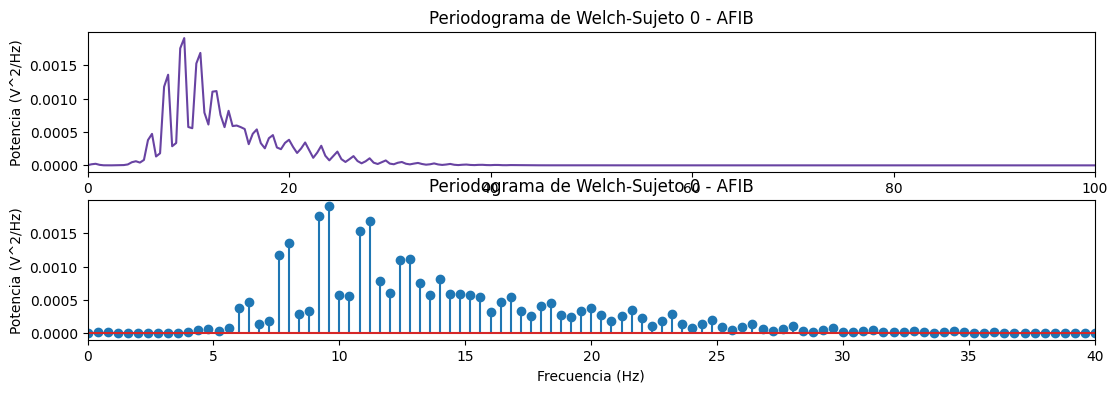

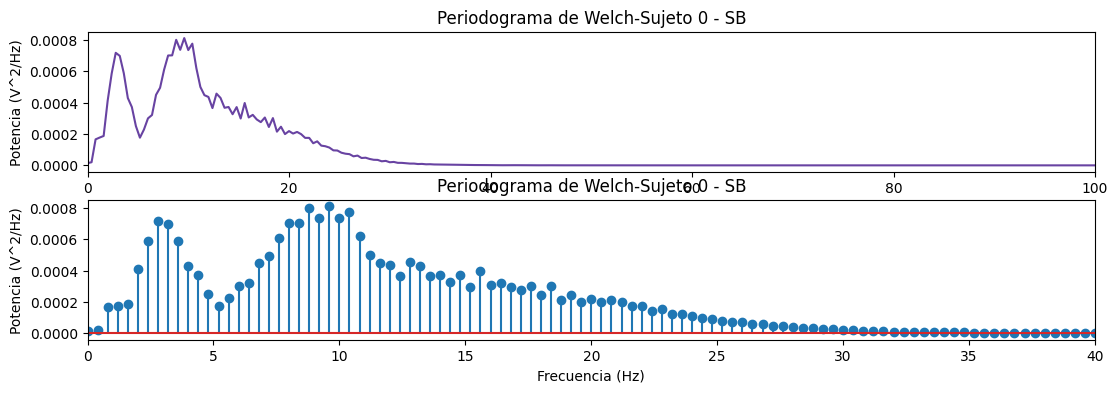

In [ ]:
welch_AFIB,f=welch(senales_AFIB,Fs)
welch_SB,f=welch(senales_SB,Fs)
sujeto=0
#AFIB
plt.figure(figsize=(13, 4))
plt.subplot(2,1,1)
plt.plot(f,welch_AFIB[sujeto],color='#6843A2')
plt.title(f'Periodograma de Welch-Sujeto {sujeto} - AFIB')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.xlim([0,100])

plt.subplot(2,1,2)
plt.stem(f, welch_AFIB[sujeto])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.xlim([0, 40])  # rango para el eje X
#plt.ylim([0, 0.003])  # rango para el eje y
plt.title(f'Periodograma de Welch-Sujeto {sujeto} - AFIB')
plt.show()

#SB
plt.figure(figsize=(13, 4))
plt.subplot(2,1,1)
plt.plot(f,welch_SB[sujeto],color='#6843A2')
plt.title(f'Periodograma de Welch-Sujeto {sujeto} - SB')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.xlim([0,100])

plt.subplot(2,1,2)
plt.stem(f, welch_SB[sujeto])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.xlim([0, 40])  # rango para el eje X
#plt.ylim([0, 0.002])  # rango para el eje y
plt.title(f'Periodograma de Welch-Sujeto {sujeto} - SB')
plt.show()

In [ ]:
def fMP(senal,f):
  max_potencia = np.zeros(len(senal), dtype=int)
  frecuencia = np.zeros(len(senal))
  try:
    for i in range(len(senal)):
      max_potencia[i] = np.argmax(np.abs(senal[i][:]))
      frecuencia[i] = f[:][max_potencia[i]]
  except ValueError:
    # Si ocurre un error en el delineado, retornar NaN
    frecuencia[i] = np.nan
  return frecuencia

In [ ]:
frecuencia_AFIB=fMP(welch_AFIB,f)
frecuencia_SB=fMP(welch_SB,f)

tablita_frec_AFIB=pd.DataFrame(frecuencia_AFIB)
print(pd.DataFrame(frecuencia_AFIB))

tablita_frec_SB=pd.DataFrame(frecuencia_SB)
print(pd.DataFrame(frecuencia_SB))

         0
0      9.6
1     10.4
2      6.4
3      2.8
4     20.8
...    ...
1775  19.6
1776   6.4
1777  12.0
1778  10.8
1779  18.4

[1780 rows x 1 columns]
         0
0      9.6
1      9.2
2     10.0
3      8.8
4      9.6
...    ...
3884  12.8
3885  11.2
3886   0.8
3887   8.8
3888   5.6

[3889 rows x 1 columns]


## 6. Crear una rutina que aplique sobre todos los archivos de la base de datos la rutina 5 y almacene los resultados en un dataframe:

In [ ]:
#AFIB
promedio_duracion_T_AFIB = pd.DataFrame(Duracion_T(senales_AFIB))
promedio_distancia_QRS_AFIB = pd.DataFrame(Duracion_QRS(senales_AFIB))
promedio_distancia_P_AFIB = pd.DataFrame(Tiempo_entre_P(senales_AFIB))
Duracion_QT_AFIB = pd.DataFrame(Duracion_QT(senales_AFIB))
Media_intervalos_RR_AFIB = pd.DataFrame(Media_intervalos_RR(senales_AFIB))
Varianza_intervalos_RR_AFIB = pd.DataFrame(Varianza_intervalos_RR(senales_AFIB))
frecuencia_cardiaca_AFIB = pd.DataFrame(frecuencia_cardiaca(senales_AFIB))


/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local

In [ ]:
for i in range(senales_SB.shape[0]):
    senales_SB[i] = np.nan_to_num(senales_SB[i], nan=np.nanmedian(senales_SB[i]))
#SB
promedio_duracion_T_SB=pd.DataFrame(Duracion_T(senales_SB))
promedio_distancia_QRS_SB=pd.DataFrame(Duracion_QRS(senales_SB))
promedio_distancia_P_SB=pd.DataFrame(Tiempo_entre_P(senales_SB))
Duracion_QT_SB=pd.DataFrame(Duracion_QT(senales_SB))
Media_intervalos_RR_SB=pd.DataFrame(Media_intervalos_RR(senales_SB))
Varianza_intervalos_RR_SB=pd.DataFrame(Varianza_intervalos_RR(senales_SB))
frecuencia_cardiaca_SB=pd.DataFrame(frecuencia_cardiaca(senales_SB))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/di

In [ ]:
tablita_nombres_AFIB=pd.DataFrame(nombres_AFIB)
tablita_nombres_SB=pd.DataFrame(nombres_SB)

#AFIB - Outcome como 1

df_concat_AFIB = pd.concat([tablita_nombres_AFIB[:]], axis=1)
df_concat_AFIB['Patología'] = 'AFIB'

df_concat_AFIB ['Duracion onda T'] = promedio_duracion_T_AFIB
df_concat_AFIB ['Duracion del complejo QRS'] = promedio_distancia_QRS_AFIB
df_concat_AFIB ['Tiempo entre las ondas P (intervalos PP)'] = promedio_distancia_P_AFIB
df_concat_AFIB ['Duracion del complejo QT'] = Duracion_QT_AFIB
df_concat_AFIB ['Media intervalos RR'] = Media_intervalos_RR_AFIB
df_concat_AFIB ['Varianza intervalos RR'] = Varianza_intervalos_RR_AFIB
df_concat_AFIB ['Frecuencia Cardíaca'] = frecuencia_cardiaca_AFIB
df_concat_AFIB['fMP'] = tablita_frec_AFIB
df_concat_AFIB['Outcome'] = 1
df_concat_AFIB.columns = ['Registro','Patología','Duración onda T','Duración del complejo QRS','Tiempo entre las ondas P (intervalos PP)','Duración del complejo QT','Media intervalos RR','Varianza intervalos RR','Frecuencia Cardíaca','Frecuencia de Potencia Máxima','Outcome']

print(df_concat_AFIB)

                        Registro Patología  Duración onda T  \
0     MUSE_20180113_171327_27000      AFIB         0.051467   
1     MUSE_20180114_075026_69000      AFIB         0.062875   
2     MUSE_20180113_133901_16000      AFIB         0.058714   
3     MUSE_20180116_123940_90000      AFIB         0.064875   
4     MUSE_20180114_075003_61000      AFIB         0.032417   
...                          ...       ...              ...   
1775  MUSE_20180116_120939_86000      AFIB              NaN   
1776  MUSE_20180114_134126_54000      AFIB              NaN   
1777  MUSE_20180115_131040_20000      AFIB              NaN   
1778  MUSE_20180116_170450_55000      AFIB              NaN   
1779  MUSE_20180115_131524_93000      AFIB              NaN   

      Duración del complejo QRS  Tiempo entre las ondas P (intervalos PP)  \
0                      0.060286                                  0.647333   
1                      0.077867                                  0.616727   
2           

In [ ]:
#SB
df_concat_SB = pd.concat([tablita_nombres_SB[:]], axis=1)
df_concat_SB['Patología'] = 'SB'

df_concat_SB ['Duracion onda T'] = promedio_duracion_T_SB
df_concat_SB ['Duracion del complejo QRS'] = promedio_distancia_QRS_SB
df_concat_SB ['Tiempo entre las ondas P (intervalos PP)'] = promedio_distancia_P_SB
df_concat_SB ['Duracion del complejo QT'] = Duracion_QT_SB
df_concat_SB ['Media intervalos RR'] = Media_intervalos_RR_SB
df_concat_SB ['Varianza intervalos RR'] = Varianza_intervalos_RR_SB
df_concat_SB ['Frecuencia Cardíaca'] = frecuencia_cardiaca_SB
df_concat_SB['fMP'] = tablita_frec_SB
df_concat_SB['Outcome'] = 0
df_concat_SB.columns = ['Registro','Patología','Duración onda T','Duración del complejo QRS','Tiempo entre las ondas P (intervalos PP)','Duración del complejo QT','Media intervalos RR','Varianza intervalos RR','Frecuencia Cardíaca','Frecuencia de Potencia Máxima','Outcome']

print('\n',df_concat_SB)


                         Registro Patología  Duración onda T  \
0     MUSE_20180112_073319_29000        SB         0.152889   
1     MUSE_20180113_121940_44000        SB         0.092000   
2     MUSE_20180112_120347_79000        SB         0.084600   
3     MUSE_20180114_075128_92000        SB         0.112222   
4     MUSE_20180118_174026_42000        SB         0.103250   
...                          ...       ...              ...   
3884  MUSE_20180114_070348_17000        SB         0.118444   
3885  MUSE_20180114_134724_10000        SB         0.131200   
3886  MUSE_20180113_122544_20000        SB         0.042200   
3887  MUSE_20180114_074720_85000        SB         0.079333   
3888  MUSE_20180116_133908_01000        SB         0.156667   

      Duración del complejo QRS  Tiempo entre las ondas P (intervalos PP)  \
0                      0.055000                                  1.126800   
1                      0.073250                                  1.004333   
2         

In [ ]:
with pd.ExcelWriter('caracteristicas_P4.xlsx', engine='openpyxl') as writer:
    df_concat_AFIB.to_excel(writer, sheet_name='AFIB', index=True)
    df_concat_SB.to_excel(writer, sheet_name='SB', index=True)

## Todos los puntos realizados a continuación son con las características definidas

## 7. Código y análisis de resultados.
Donde se discutan por los menos tres diferentes arquitecturas de red (10%) y las matrices de confusión obtenidas (10%), de una red neuronal que permita la clasificación de las dos patologías cardiacas.

In [ ]:
#Generate descriptive statistics.

df=pd.concat([df_concat_AFIB,df_concat_SB],axis=0,ignore_index=True)

with pd.ExcelWriter('caracteristicas_P4_juntas.xlsx', engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='features', index=True)

In [ ]:
df= pd.read_excel('/content/drive/MyDrive/ColabNotebooks/Biosenales/Proyecto_4/caracteristicas_P4_juntas.xlsx')
df.describe()

,Unnamed: 0,Duración onda T,Duración del complejo QRS,Tiempo entre las ondas P (intervalos PP),Duración del complejo QT,Media intervalos RR,Varianza intervalos RR,Frecuencia Cardíaca,Frecuencia de Potencia Máxima,Outcome
count,5669.000000,4272.000000,4167.000000,4263.000000,4272.000000,5668.000000,5668.000000,5667.000000,5669.000000,5669.000000
mean,2834.000000,0.099222,0.075467,1.029465,0.161691,0.945583,0.019244,70.593498,8.803316,0.313988
std,1636.643669,0.033016,0.019414,0.157484,0.035310,0.219964,0.058684,23.876143,3.441482,0.464153
min,0.000000,0.014500,0.029000,0.358286,0.091143,0.356538,0.000003,25.414194,0.800000,0.000000
25%,1417.000000,0.079556,0.062000,1.013000,0.136750,0.795273,0.000391,55.773657,6.800000,0.000000
50%,2834.000000,0.094739,0.071500,1.048750,0.158250,1.027778,0.002244,58.694625,9.200000,0.000000
75%,4251.000000,0.115514,0.084619,1.103000,0.180518,1.081500,0.020288,80.537433,10.800000,1.000000
max,5668.000000,0.666000,0.221333,2.381333,0.380444,2.437333,2.234723,171.166473,25.200000,1.000000


In [ ]:
# Step 3 - Creating Arrays for the Features and the Response Variable
target_column = ['Outcome']
#df=df.drop(columns=['Registro','Patología'])
predictors = list(set(list(df.columns))-set(target_column))
print(predictors)
#Se normalizan las variables
df[predictors] = df[predictors]/df[predictors].max()
df.describe()

#%% Step 4 - Creating the Training and Test Datasets
X = df[predictors].values
y = df[target_column].values

#the same seed is used to partition to obtain the same results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

# Create an imputer to replace missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and testing data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print(f"\nTamaño del conjunto de entrenamiento: {(X_train.shape)} X y {y_train.shape} en Y")
print(f"Tamaño del conjunto de prueba: {(X_test.shape)} X y {y_test.shape} en Y")


['Frecuencia de Potencia Máxima', 'Media intervalos RR', 'Duración del complejo QT', 'Frecuencia Cardíaca', 'Duración del complejo QRS', 'Duración onda T', 'Varianza intervalos RR', 'Tiempo entre las ondas P (intervalos PP)']

Tamaño del conjunto de entrenamiento: (3968, 8) X y (3968,) en Y
Tamaño del conjunto de prueba: (1701, 8) X y (1701,) en Y


In [ ]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Arquitectura 1

- 4 Hidden layers
- 8 neuronas cada una
- activation = 'relu'(Rectified Linear Unit)
- solver = 'adam' (Adaptive momentum)
- max_iter = 600

Parámetros tomados de:
M. Roy, S. Majumder, A. Halder, y U. Biswas, “ECG-NET: A deep LSTM autoencoder for detecting anomalous ECG”, Eng. Appl. Artif. Intell., vol. 124, p. 106484, sep. 2023, doi: 10.1016/j.engappai.2023.106484.

MLPClassifier(hidden_layer_sizes=(8, 8, 8, 8), max_iter=600)
              precision    recall  f1-score   support

          SB       0.96      0.99      0.97      2703
        AFIB       0.97      0.92      0.94      1265

    accuracy                           0.96      3968
   macro avg       0.97      0.95      0.96      3968
weighted avg       0.96      0.96      0.96      3968

              precision    recall  f1-score   support

          SB       0.97      0.99      0.98      1186
        AFIB       0.97      0.94      0.95       515

    accuracy                           0.97      1701
   macro avg       0.97      0.96      0.97      1701
weighted avg       0.97      0.97      0.97      1701

Confusion matrix, without normalization
[[2666   37]
 [ 106 1159]]
Confusion matrix, without normalization
[[1171   15]
 [  31  484]]


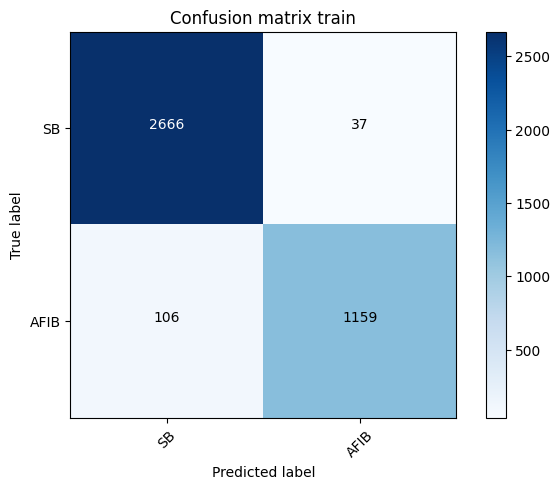

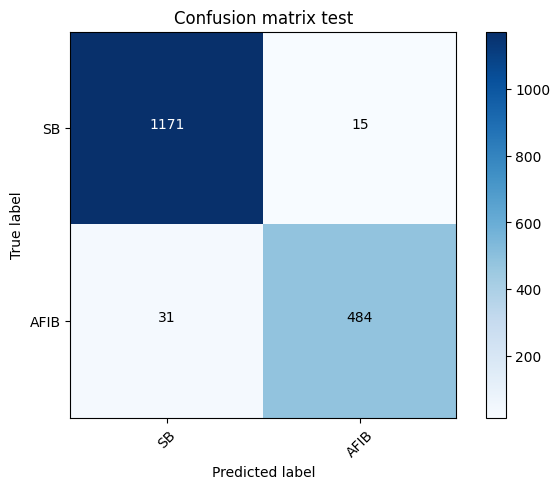

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8,8), activation='relu', solver='adam', max_iter=600)
print(mlp)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

target_names = ['SB', 'AFIB']

print(classification_report(y_train,predict_train,target_names=target_names))

print(classification_report(y_test,predict_test,target_names=target_names))

mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')

mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')



In [ ]:
def generate_classification_report(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, output_dict=True, target_names=target_names)
    f1_sb = report['SB']['f1-score']
    f1_afib = report['AFIB']['f1-score']
    f1_weighted_avg = report['weighted avg']['f1-score']
    support_sb = report['SB']['support']
    support_afib = report['AFIB']['support']

    data = {'Metric': ['f1-score', 'Support'],
            'SB': [f1_sb, support_sb],
            'AFIB': [f1_afib, support_afib],
            'Weighted Avg': [f1_weighted_avg, support_sb + support_afib]}

    return pd.DataFrame(data)

In [ ]:
train1=generate_classification_report(y_train, predict_train, target_names)
test1=generate_classification_report(y_test, predict_test, target_names)
print(f'{train1}\n{test1}')

     Metric           SB         AFIB  Weighted Avg
0  f1-score     0.973881     0.941894      0.963684
1   Support  2703.000000  1265.000000   3968.000000
     Metric           SB        AFIB  Weighted Avg
0  f1-score     0.980737    0.954635      0.972834
1   Support  1186.000000  515.000000   1701.000000


Cambio del parámetro '**solver**' pasando de '*adam*' a '*sgd*' (stochastic gradient descent.)

MLPClassifier(hidden_layer_sizes=(8, 8, 8, 8), max_iter=600, solver='sgd')
              precision    recall  f1-score   support

          SB       0.94      0.97      0.95      2703
        AFIB       0.94      0.86      0.89      1265

    accuracy                           0.94      3968
   macro avg       0.94      0.91      0.92      3968
weighted avg       0.94      0.94      0.93      3968

              precision    recall  f1-score   support

          SB       0.96      0.98      0.97      1186
        AFIB       0.95      0.90      0.92       515

    accuracy                           0.95      1701
   macro avg       0.95      0.94      0.95      1701
weighted avg       0.95      0.95      0.95      1701

Confusion matrix, without normalization
[[2630   73]
 [ 182 1083]]
Confusion matrix, without normalization
[[1161   25]
 [  52  463]]


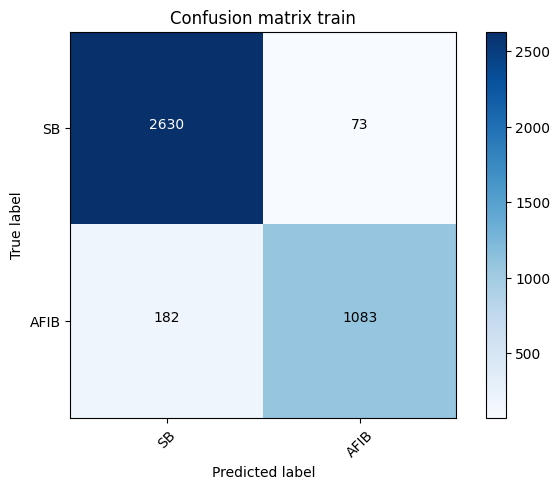

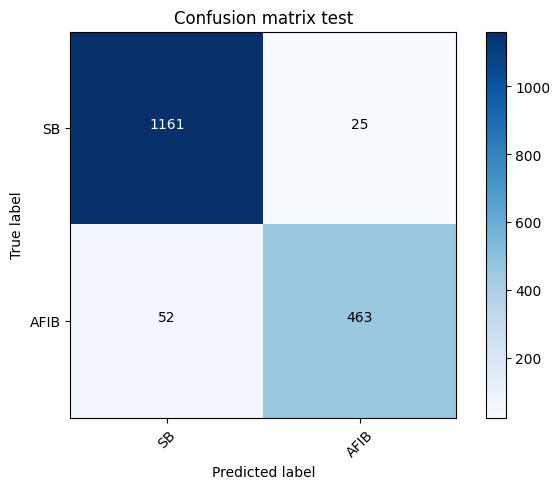

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8,8), activation='relu', solver='sgd', max_iter=600, learning_rate='constant')
print(mlp)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)


print(classification_report(y_train,predict_train,target_names=target_names))

print(classification_report(y_test,predict_test,target_names=target_names))

mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

In [ ]:
train1_1=generate_classification_report(y_train, predict_train, target_names)
test1_1=generate_classification_report(y_test, predict_test, target_names)
print(f'{train1_1}\n{test1_1}')

     Metric           SB         AFIB  Weighted Avg
0  f1-score     0.953762     0.894672      0.934924
1   Support  2703.000000  1265.000000   3968.000000
     Metric           SB       AFIB  Weighted Avg
0  f1-score     0.967903    0.92323      0.954378
1   Support  1186.000000  515.00000   1701.000000


### Arquitectura 2
- 4 hidden layers
- 2 de 8 y 2 de 10 neuronas

MLPClassifier(hidden_layer_sizes=(8, 8), max_iter=600)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

          SB       0.96      0.98      0.97      2703
        AFIB       0.95      0.91      0.93      1265

    accuracy                           0.96      3968
   macro avg       0.96      0.95      0.95      3968
weighted avg       0.96      0.96      0.96      3968

              precision    recall  f1-score   support

          SB       0.97      0.98      0.98      1186
        AFIB       0.96      0.94      0.95       515

    accuracy                           0.97      1701
   macro avg       0.97      0.96      0.96      1701
weighted avg       0.97      0.97      0.97      1701

Confusion matrix, without normalization
[[2648   55]
 [ 108 1157]]
Confusion matrix, without normalization
[[1166   20]
 [  32  483]]


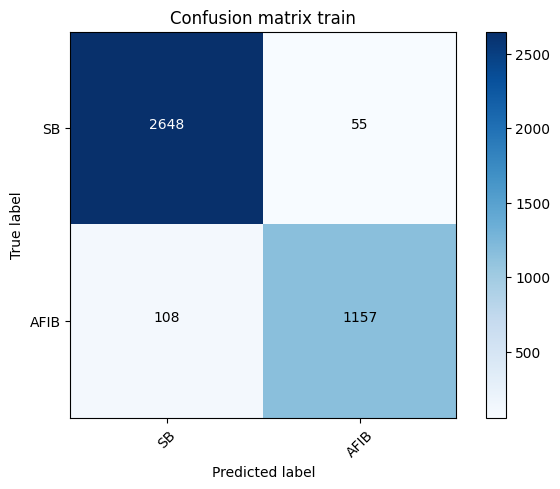

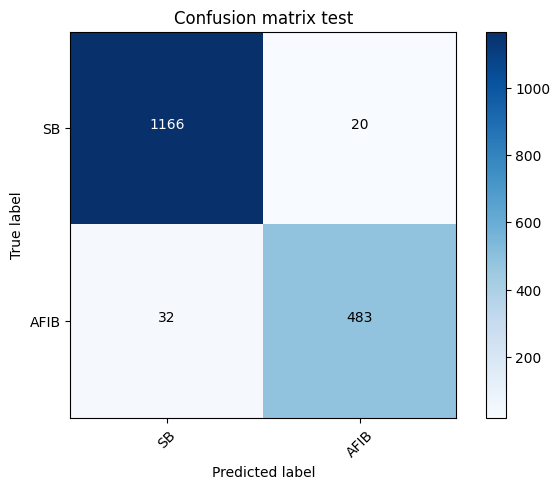

In [ ]:

mlp = MLPClassifier(hidden_layer_sizes=(8,8), activation='relu', solver='adam', max_iter=600)
print(mlp)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)


print(classification_report(y_train,predict_train,target_names=target_names))

print(classification_report(y_test,predict_test,target_names=target_names))

mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

In [ ]:
train2=generate_classification_report(y_train, predict_train, target_names)
test2=generate_classification_report(y_test, predict_test, target_names)
print(f'{train2}\n{test2}')

     Metric           SB         AFIB  Weighted Avg
0  f1-score     0.970141     0.934195      0.958681
1   Support  2703.000000  1265.000000   3968.000000
     Metric           SB        AFIB  Weighted Avg
0  f1-score     0.978188    0.948919      0.969327
1   Support  1186.000000  515.000000   1701.000000


MLPClassifier(activation='logistic', hidden_layer_sizes=(8, 8), max_iter=600)
              precision    recall  f1-score   support

          SB       0.93      0.96      0.94      2703
        AFIB       0.90      0.84      0.87      1265

    accuracy                           0.92      3968
   macro avg       0.92      0.90      0.91      3968
weighted avg       0.92      0.92      0.92      3968

              precision    recall  f1-score   support

          SB       0.95      0.95      0.95      1186
        AFIB       0.89      0.88      0.88       515

    accuracy                           0.93      1701
   macro avg       0.92      0.92      0.92      1701
weighted avg       0.93      0.93      0.93      1701

Confusion matrix, without normalization
[[2588  115]
 [ 197 1068]]
Confusion matrix, without normalization
[[1128   58]
 [  61  454]]


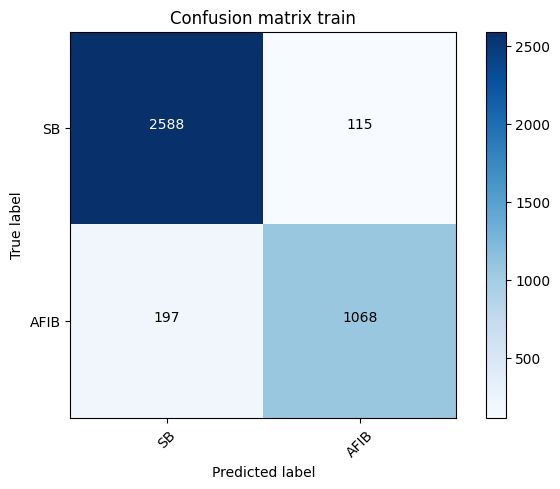

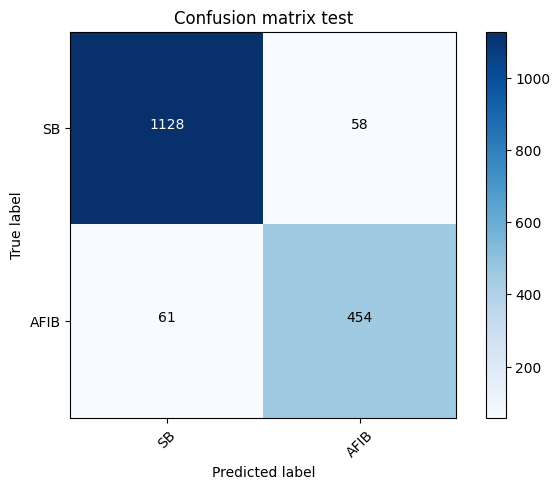

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8), activation='logistic', solver='adam', max_iter=600)
print(mlp)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)


print(classification_report(y_train,predict_train,target_names=target_names))

print(classification_report(y_test,predict_test,target_names=target_names))

mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

In [ ]:
train2_2=generate_classification_report(y_train, predict_train, target_names)
test2_2=generate_classification_report(y_test, predict_test, target_names)
print(f'{train2_2}\n{test2_2}')

     Metric           SB         AFIB  Weighted Avg
0  f1-score     0.943149     0.872549      0.920641
1   Support  2703.000000  1265.000000   3968.000000
     Metric           SB        AFIB  Weighted Avg
0  f1-score     0.949895    0.884129      0.929983
1   Support  1186.000000  515.000000   1701.000000


### Arquitectura 3
- 2 Hidden layer
- 8 neuronas

En este caso se variaron la cantidad de datos de entrenamiento y test


Tamaño del conjunto de entrenamiento: 3401
Tamaño del conjunto de prueba: 2268
MLPClassifier(hidden_layer_sizes=(8, 8), max_iter=1000)
              precision    recall  f1-score   support

          SB       0.94      0.99      0.97      2315
        AFIB       0.97      0.87      0.92      1086

    accuracy                           0.95      3401
   macro avg       0.96      0.93      0.94      3401
weighted avg       0.95      0.95      0.95      3401

              precision    recall  f1-score   support

          SB       0.96      0.99      0.97      1574
        AFIB       0.97      0.90      0.94       694

    accuracy                           0.96      2268
   macro avg       0.96      0.95      0.96      2268
weighted avg       0.96      0.96      0.96      2268

Confusion matrix, without normalization
[[2289   26]
 [ 136  950]]
Confusion matrix, without normalization
[[1555   19]
 [  66  628]]


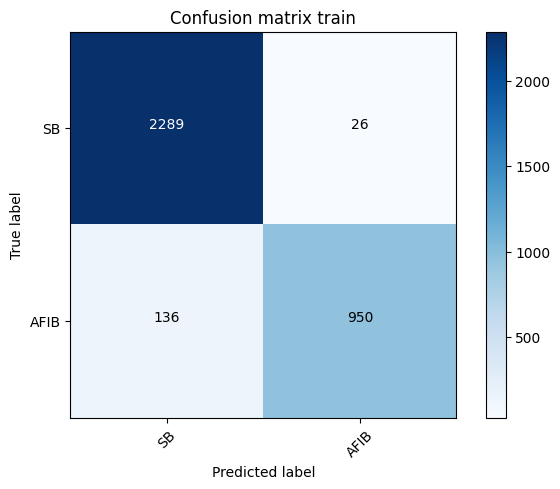

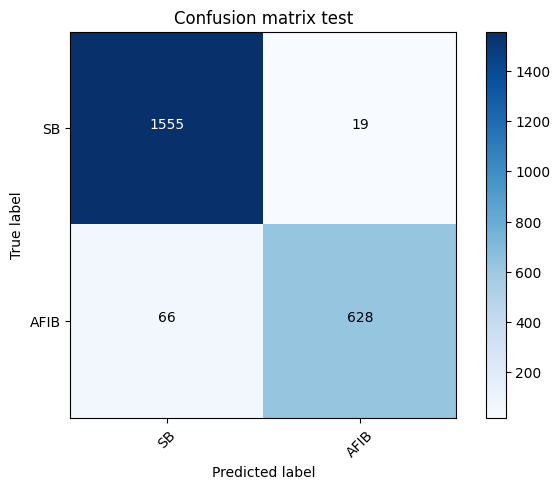

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
# Create an imputer to replace missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and testing data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
print(f"\nTamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")
#Four hidden layer each layer with eigth neurons
mlp = MLPClassifier(hidden_layer_sizes=(8,8), activation='relu', solver='adam', max_iter=1000)

print(mlp)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)


print(classification_report(y_train,predict_train,target_names=target_names))

print(classification_report(y_test,predict_test,target_names=target_names))

mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

In [ ]:
train3=generate_classification_report(y_train, predict_train, target_names)
test3=generate_classification_report(y_test, predict_test, target_names)
print(f'{train3}\n{test3}')

     Metric           SB         AFIB  Weighted Avg
0  f1-score     0.965823     0.921435      0.951649
1   Support  2315.000000  1086.000000   3401.000000
     Metric           SB        AFIB  Weighted Avg
0  f1-score     0.973396    0.936614      0.962141
1   Support  1574.000000  694.000000   2268.000000


Se disminuyen la cantidad de neuronas por capa

MLPClassifier(hidden_layer_sizes=(6, 6), max_iter=1000)
              precision    recall  f1-score   support

          SB       0.95      0.99      0.97      2315
        AFIB       0.97      0.88      0.92      1086

    accuracy                           0.95      3401
   macro avg       0.96      0.93      0.94      3401
weighted avg       0.95      0.95      0.95      3401

              precision    recall  f1-score   support

          SB       0.96      0.99      0.98      1574
        AFIB       0.98      0.92      0.95       694

    accuracy                           0.97      2268
   macro avg       0.97      0.95      0.96      2268
weighted avg       0.97      0.97      0.97      2268

Confusion matrix, without normalization
[[2283   32]
 [ 130  956]]
Confusion matrix, without normalization
[[1559   15]
 [  58  636]]


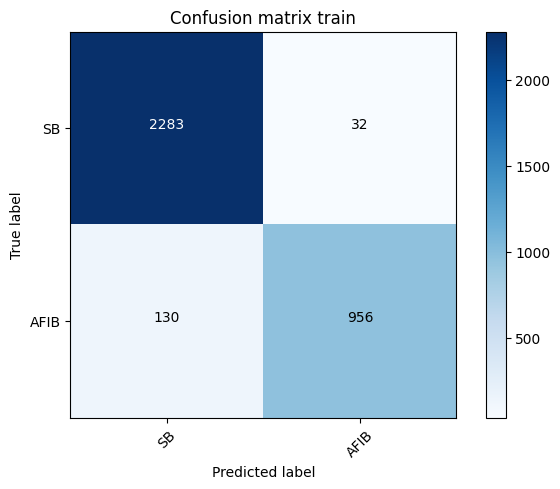

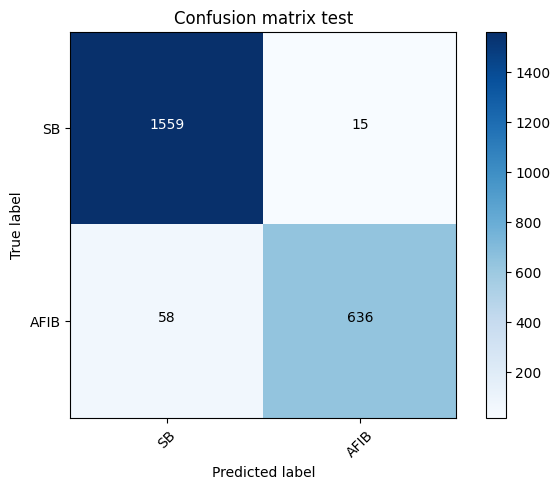

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(6,6), activation='relu', solver='adam', max_iter=1000)

print(mlp)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)


print(classification_report(y_train,predict_train,target_names=target_names))

print(classification_report(y_test,predict_test,target_names=target_names))

mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,
                      title='Confusion matrix train')
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

In [ ]:
train3_3=generate_classification_report(y_train, predict_train, target_names)
test3_3=generate_classification_report(y_test, predict_test, target_names)
print(f'{train3_3}\n{test3_3}')

     Metric           SB        AFIB  Weighted Avg
0  f1-score     0.965736     0.92189      0.951735
1   Support  2315.000000  1086.00000   3401.000000
     Metric           SB        AFIB  Weighted Avg
0  f1-score     0.977123    0.945725      0.967515
1   Support  1574.000000  694.000000   2268.000000


In [ ]:
architectures = [1, 2, 3]
train_results = [train1, train2, train3]
test_results = [test1, test2, test3]
train2_results = [train1_1, train2_2, train3_3]
test2_results = [test1_1, test2_2, test3_3]

for i, arch in enumerate(architectures):
    print(f"Arquitectura {arch}")
    print("--------- Entrenamiento ---------")
    print(train_results[i])
    print("--------- Prueba ---------")
    print(test_results[i])
    print("--------- 2do Entrenamiento ---------")
    print(train2_results[i])
    print("--------- 2da Prueba ---------")
    print(test2_results[i])
    print("\n")

Arquitectura 1
--------- Entrenamiento ---------
     Metric           SB         AFIB  Weighted Avg
0  f1-score     0.973881     0.941894      0.963684
1   Support  2703.000000  1265.000000   3968.000000
--------- Prueba ---------
     Metric           SB        AFIB  Weighted Avg
0  f1-score     0.980737    0.954635      0.972834
1   Support  1186.000000  515.000000   1701.000000
--------- 2do Entrenamiento ---------
     Metric           SB         AFIB  Weighted Avg
0  f1-score     0.953762     0.894672      0.934924
1   Support  2703.000000  1265.000000   3968.000000
--------- 2da Prueba ---------
     Metric           SB       AFIB  Weighted Avg
0  f1-score     0.967903    0.92323      0.954378
1   Support  1186.000000  515.00000   1701.000000


Arquitectura 2
--------- Entrenamiento ---------
     Metric           SB         AFIB  Weighted Avg
0  f1-score     0.970141     0.934195      0.958681
1   Support  2703.000000  1265.000000   3968.000000
--------- Prueba ---------
     M

Los hiperparámetros de la función de activación(`activation`), el algoritmo de optimización (`‘solver`) y la cantidad máxima de iteraciones se definieron como se encontró en un ejemplo de la teoría inicialmente, sin embargo, se fueron cambiando para analizar las estructuras que mejor respuesta daban, teniendo en cuenta el tiempo de programación, los resultados de exactitud, f1-score, donde se relaciona la precisión y la sensibilidad, y el promedio ponderado de las métricas. Igualmente, se incluyó la variación de hidden layers y neuronas para analizar las respuestas de los modelos con las arquitecturas diseñadas. Para cada arquitectura se varió un hiperparámetro.

Para la **Arquitectura 1 y 2** los datos se dividieron en:

- Entrenamiento: 3968 muestras (2703 SB y 1265 AFIB).
- Prueba: 1701 muestras (1186 SB y 515 AFIB).

Para la **Arquitectura 3** los datos se dividieron en:

- Entrenamiento: 3401 muestras (2315 SB y 1086 AFIB).
- Prueba: 2268 muestras (1574 SB y 694 AFIB).


 ***Arquitectura 1***

Resultados con optimizador `adam`:

El modelo mostró una ligera mejora en el conjunto de prueba, indicando un buen ajuste y generalización.

Resultados con `sgd`:

Al cambiar el optimizador a sgd, se observaron valores inferiores en los valores de interés. Por lo que se denota que el cambio de optimizador disminuyó el rendimiento en ambas clases, tanto en entrenamiento como en prueba, resaltando una menor sensibilidad para AFIB.

 ***Arquitectura 2***

En esta se varió el hiperparámetro de la función de activación, pasando de `relu` a `logistic`. Al igual que en la arquitectura anterior, se evidencia disminución de porcentajes que sí coinciden con el outcome real y la prueba presenta un aumento del 1% en las métricas en comparación con el entrenamiento para ambos casos.

 ***Arquitectura 3***

Para esta arquitectura se utilizó distinta cantidad de datos de prueba pues se cambió la cantidad de datos de prueba a 40% para ambas pruebas y se disminuyeron la cantidad de neuronas por capa, pasando de 8 a 6.

En esta arquitectura se denotan valores muy similares en las respuestas de los modelos, donde hay un promedio ponderado de 95% para los entrenamientos y 96-97% para las respectivas pruebas. Adicionalmente se ve una leve mejoría del primer entrenamiento al segundo, donde este último tiene menor cantidad de neuronas, pero siendo 0.4% mejor en porcentaje de f1-score.  


En general, los modelos presentados tienen buenos resultados ya que son porcentajes significativos para categorizar correctamente la enfermedad. Entre ellos, el que mejor características tiene es el que presenta la arquitectura 1 con el optimizador `adam` pues es el que menos datos incorrectos arroja y el tiempo de procesamiento no fue extenso.

## 8. Consultar cómo funciona, realizar y discutir un ejemplo con los datos, del algoritmo de K means (10%) y máquinas de soporte vectorial (SVM) (10%)

### SVM

Es un algoritmo de clasificación y regresión que utiliza la teoría de aprendizaje de las máquinas para mejorar la precisión de las predicciones y evita ajustar excesivamente los datos. Este algoritmo inicialmente utiliza una transformación no lineal de los datos de entrenamiento y después realiza una búsqueda de ecuaciones de regresión en los datos transformados para separar las clases o ajustar el objetivo [3].

In [ ]:
drive.mount('/content/drive',force_remount=True)

df= pd.read_excel('/content/drive/MyDrive/ColabNotebooks/Biosenales/Proyecto_4/caracteristicas_P4_juntas.xlsx')
df.describe()

Mounted at /content/drive


,Unnamed: 0,Duración onda T,Duración del complejo QRS,Tiempo entre las ondas P (intervalos PP),Duración del complejo QT,Media intervalos RR,Varianza intervalos RR,Frecuencia Cardíaca,Frecuencia de Potencia Máxima,Outcome
count,5669.000000,4272.000000,4167.000000,4263.000000,4272.000000,5668.000000,5668.000000,5667.000000,5669.000000,5669.000000
mean,2834.000000,0.099222,0.075467,1.029465,0.161691,0.945583,0.019244,70.593498,8.803316,0.313988
std,1636.643669,0.033016,0.019414,0.157484,0.035310,0.219964,0.058684,23.876143,3.441482,0.464153
min,0.000000,0.014500,0.029000,0.358286,0.091143,0.356538,0.000003,25.414194,0.800000,0.000000
25%,1417.000000,0.079556,0.062000,1.013000,0.136750,0.795273,0.000391,55.773657,6.800000,0.000000
50%,2834.000000,0.094739,0.071500,1.048750,0.158250,1.027778,0.002244,58.694625,9.200000,0.000000
75%,4251.000000,0.115514,0.084619,1.103000,0.180518,1.081500,0.020288,80.537433,10.800000,1.000000
max,5668.000000,0.666000,0.221333,2.381333,0.380444,2.437333,2.234723,171.166473,25.200000,1.000000


In [ ]:
# Separar las características (X) y la variable objetivo (y)
y = df['Outcome']  # Variable objetivo: enfermedad
X = df.iloc[:, 1:].drop(columns=['Patología', 'Registro', 'Outcome'])  # Características (eliminamos 'Patología', 'Registro' y 'Outcome')
print("\nVariable objetivo (y):")
print(y)
print("\nCaracterísticas (X):")
print(X)



Variable objetivo (y):
0       1
1       1
2       1
3       1
4       1
       ..
5664    0
5665    0
5666    0
5667    0
5668    0
Name: Outcome, Length: 5669, dtype: int64

Características (X):
      Duración onda T  Duración del complejo QRS  \
0            0.051467                   0.060286   
1            0.062875                   0.077867   
2            0.058714                   0.100308   
3            0.064875                   0.072267   
4            0.032417                   0.045913   
...               ...                        ...   
5664         0.118444                   0.079500   
5665         0.131200                   0.070667   
5666         0.042200                   0.114667   
5667         0.079333                   0.066500   
5668         0.156667                   0.092250   

      Tiempo entre las ondas P (intervalos PP)  Duración del complejo QT  \
0                                     0.647333                  0.118167   
1                        

In [ ]:
# Dividir los datos en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(f"\nTamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

(4535, 8)
(4535,)
(1134, 8)
(1134,)

Tamaño del conjunto de entrenamiento: 4535
Tamaño del conjunto de prueba: 1134


In [ ]:
# Crear el modelo SVM con kernel lineal
svm_model = SVC(kernel='rbf', random_state=42)

# Reemplazar los nan por la media
imputer = SimpleImputer(strategy='mean')

# Ajustar los datos
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Entrenar el modelo con los datos de entrenamiento
svm_model.fit(X_train, y_train)

SVC(random_state=42)


Precisión del modelo: 0.9215167548500882

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       774
           1       0.88      0.88      0.88       360

    accuracy                           0.92      1134
   macro avg       0.91      0.91      0.91      1134
weighted avg       0.92      0.92      0.92      1134


Matriz de confusión:
[[730  44]
 [ 45 315]]


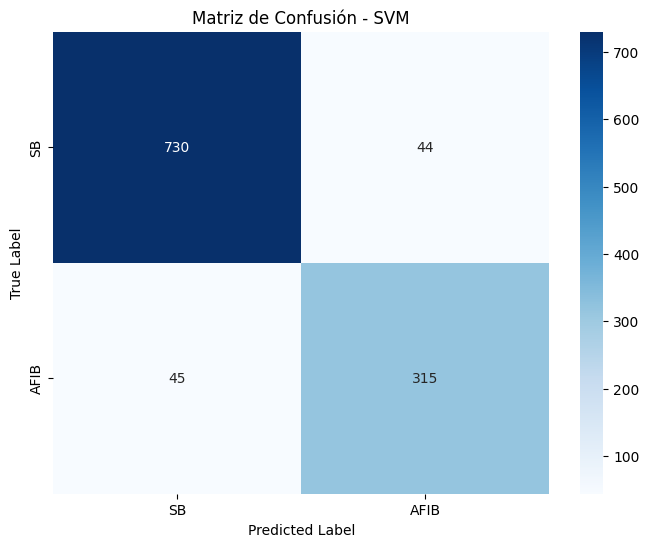

In [ ]:
# Hacer predicciones sobre el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Evaluar el modelo
print(f"\nPrecisión del modelo: {accuracy_score(y_test, y_pred)}")

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['SB', 'AFIB'], yticklabels=['SB', 'AFIB'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión - SVM")
plt.show()

### Kmeans
Está técnica identifica grupos en los datos de tal manera que todos los datos del grupo (clúster) son datos con características similares mientras que los datos de los otros grupos son diferentes. Por lo cual su objetivo es agrupar observaciones similares para descubrir patrones que a simple vista se desconocen, para lograrlo el algoritmo busca un número (k) de clústeres en el dataset [1].   

El número k es un hiperparámetro del algoritmo, el cual representa el número de centroides que se desean encontrar en el dataset. Para saber que k se debe de usar, se usa la regla del codo, este evalúa la suma de los errores cuadráticos (distancia al centro) para diferentes valores de k, con esto se logra identificar el número de clústeres para el que se observa un cambio significativo en la tasa de disminución de la varianza intra-cluster [1],[2]. Cuando se implementa un algoritmo para hallar el valor de k, este me arroja una gráfica en el cual se busca donde el “codo” inicia a aplanarse, ya que este indica el valor adecuado para k.


In [ ]:
drive.mount('/content/drive',force_remount=True)

df= pd.read_excel('/content/drive/MyDrive/ColabNotebooks/Biosenales/Proyecto_4/caracteristicas_P4_juntas.xlsx')
df.describe()

Mounted at /content/drive


,Unnamed: 0,Duración onda T,Duración del complejo QRS,Tiempo entre las ondas P (intervalos PP),Duración del complejo QT,Media intervalos RR,Varianza intervalos RR,Frecuencia Cardíaca,Frecuencia de Potencia Máxima,Outcome
count,5669.000000,4272.000000,4167.000000,4263.000000,4272.000000,5668.000000,5668.000000,5667.000000,5669.000000,5669.000000
mean,2834.000000,0.099222,0.075467,1.029465,0.161691,0.945583,0.019244,70.593498,8.803316,0.313988
std,1636.643669,0.033016,0.019414,0.157484,0.035310,0.219964,0.058684,23.876143,3.441482,0.464153
min,0.000000,0.014500,0.029000,0.358286,0.091143,0.356538,0.000003,25.414194,0.800000,0.000000
25%,1417.000000,0.079556,0.062000,1.013000,0.136750,0.795273,0.000391,55.773657,6.800000,0.000000
50%,2834.000000,0.094739,0.071500,1.048750,0.158250,1.027778,0.002244,58.694625,9.200000,0.000000
75%,4251.000000,0.115514,0.084619,1.103000,0.180518,1.081500,0.020288,80.537433,10.800000,1.000000
max,5668.000000,0.666000,0.221333,2.381333,0.380444,2.437333,2.234723,171.166473,25.200000,1.000000


DataFrame Original:
      Duración onda T  Duración del complejo QRS  \
0            0.051467                   0.060286   
1            0.062875                   0.077867   
2            0.058714                   0.100308   
3            0.064875                   0.072267   
4            0.032417                   0.045913   
...               ...                        ...   
5664         0.118444                   0.079500   
5665         0.131200                   0.070667   
5666         0.042200                   0.114667   
5667         0.079333                   0.066500   
5668         0.156667                   0.092250   

      Tiempo entre las ondas P (intervalos PP)  Duración del complejo QT  \
0                                     0.647333                  0.118167   
1                                     0.616727                  0.145429   
2                                     0.704500                  0.163385   
3                                     0.588000     

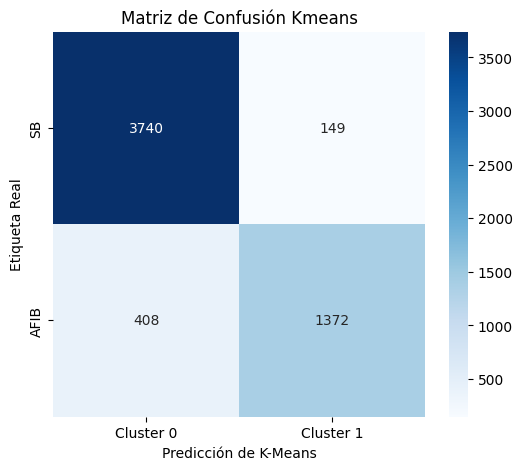

In [ ]:
# Ver el DataFrame
df = df.iloc[:, 1:].drop(columns=['Patología', 'Registro'])
print("DataFrame Original:")
print(df)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reemplazar los nan por la media
imputer = SimpleImputer(strategy='mean')

# Ajustar los datos
X_scaled = imputer.fit_transform(X_scaled)

# Aplicar K-Means con 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# y_true son las enfermedades
y_true = df['Outcome']

# Crear la matriz de confusión comparando las etiquetas reales con los clusters
conf_matrix = confusion_matrix(y_true, labels)

# Evaluar el modelo
print(f"\nPrecisión del modelo: {accuracy_score(y_true, labels)}")

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_true, labels))

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['SB', 'AFIB'])
plt.xlabel("Predicción de K-Means")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión Kmeans")
plt.show()

### Análisis
Al aplicar el SVM a nuestro conjunto de datos, se decidió dividir los datos en un conjunto de entrenamiento del 80% y de prueba del 20%, obteniendo así para el primer conjunto 4535 datos y para el segundo 1134 datos. Para este modelo se obtuvo un 92.1% de precisión, es decir, la proporción de predicciones positivas que fueron realmente positivas.   

Al observar la matriz de confusión que se obtuvo para este modelo, se observa que 730 sujetos que padecen SB fueron correctamente clasificados y para el caso del AFIB fueron 315. Por otro lado, 44 sujetos que padecen SB fueron clasificados erróneamente con AFIB y 45 sujetos con AFIB fueron erróneamente clasificados con SB.   

En la aplicación del algoritmo Kmeans, se obtuvo una precisión de 90,1%. Para su matriz de confusión se obtuvo que 3740 sujetos que padecen SB fueron correctamente clasificados y 1372 sujetos con AFIB fueron clasificados correctamente, por otro lado 149 sujetos que padecen SB fueron clasificados erróneamente con AFIB y 408 sujetos con AFIB fueron erróneamente clasificados con SB.   

Al analizar ambas aplicaciones se puede observar que con el SVM se obtuvo una mayor precisión con respecto al Kmeans, teniendo un mejor desempeño clasificando la SB en comparación con la AFIB. Esto puede ser debido a que quizás hay menos datos de pacientes con AFIB en el conjunto de entrenamiento. Aun así se debe considerar que la precisión del Kmeans también es bastante alta y que logra una mayor clasificación de sujetos.


## 9. Hacer un informe con todos los puntos anteriores (10%).
En el informe incluir: Consultar por lo menos tres equipos comerciales traen ya incorporados algoritmos de ayuda diagnóstica a partir de señales EKG (5%) y discutir brevemente las funcionalidades desde la teoría vista en el curso (5%)



1.  Irregular Rhythm Notification Feature (IRNF) aplicado en Apple Watch para la detección de arritmias [1] [2].

Los usuarios de Apple Watch tienen acceso a dos funciones de software como dispositivo médico para detectar arritmias cardiacas, como la fibrilación auricular (AFIB): la función de notificación de ritmo irregular (IRNF) y la aplicación ECG. Para las series de 1 o posterior, la IRNF analiza los datos de frecuencia del pulso recogido por el sensor fotopletismográfico (PPG) para identificar episodios de ritmos cardiacos irregulares sugestivos de fibrilación auricular para notificar al usuario cuando detecta el episodio [1].

Con watchOS 5.1.2 o posterior, Apple Watch Series 1 y posteriores son capaces de utilizar señales PPG combinadas con un algoritmo para identificar periodos de pulso irregular sugestivos de fibrilación auricular. Además de utilizar este algoritmo de identificación algoritmo en las series 4, 5 y 6, donde la aplicación ECG genera una forma de onda de electrocardiograma similar a la dada por la derivación I, y luego proporciona una clasificación de la forma de onda con ritmo sinusal (RS), fibrilación auricular (FA), frecuencia cardiaca alta, baja o no concluyente [1].

Si la detección de arritmias basada en PPG está activada, Apple Watch clasifica cada taquicograma utilizando un algoritmo patentado para determinar si puede haber un ritmo irregular. Un taquicograma irregular inicia una cascada de taquicogramas más frecuentes (con la mayor frecuencia posible, con un intervalo mínimo de 15 minutos) y su análisis. Apple Watch recopila y analiza los taquicogramas sólo si el usuario permanece quieto lo suficiente para obtener una lectura. Por lo tanto, no se monitorea todo el tiempo al usuario. Si de 5 a 6 taquicogramas se clasifican como irregulares en un periodo de 48 horas, el usuario se notifica de una arritmia potencial [1].


2.   Gili Pro BioSensor (también conocido como “Gili BioSensor System”)

Hardware y software para la medición basada en cámaras ópticas.  El dispositivo utiliza un sistema de sensores ópticos y algoritmos de software para obtener y analizar la señal de vídeo y estimar la frecuencia del pulso, la frecuencia cardíaca, la frecuencia respiratoria y/o el flujo respiratorio a partir de la captación de señales de movimiento-vibración de una superficie iluminada para evaluar su información fisiológica. Este dispositivo no está destinado a dirigir una terapia de forma independiente [3],[4].

El Gili Pro-BioSensor es un sistema óptico compuesto por una unidad de detección y una unidad móvil con una aplicación de software preinstalada. La unidad de detección óptica es una carcasa de aluminio que alberga una batería de iones de litio, una óptica de iluminación (proyector y puntero láser), un sensor de imagen digital, un medidor de alcance y un firmware para facilitar el procesamiento de datos. La óptica de iluminación se basa en láseres seguros para los ojos que cumplen los límites de emisión accesibles de los productos láser de Clase I. La unidad de detección se conecta mediante un cable USB a una unidad móvil en la que está instalada la aplicación móvil [4].

El sistema ilumina al sujeto mediante un haz de luz infrarroja cercana (NIR a ~780 nm) de baja potencia, mientras que un módulo sensor de imagen captura el patrón de luz reflejada por el sensor de luz. Los cambios en el patrón de luz reflejada se acoplan a los movimientos de la superficie iluminada, que se ven afectados por los movimientos del corazón y la respiración. El análisis de estos patrones a través de la aplicación de software se correlaciona con las frecuencias cardiaca y respiratoria, como parte de la evaluación de los signos vitales. Los valores de la frecuencia cardiaca y respiratoria se muestran en la interfaz de usuario de la unidad móvil [4].




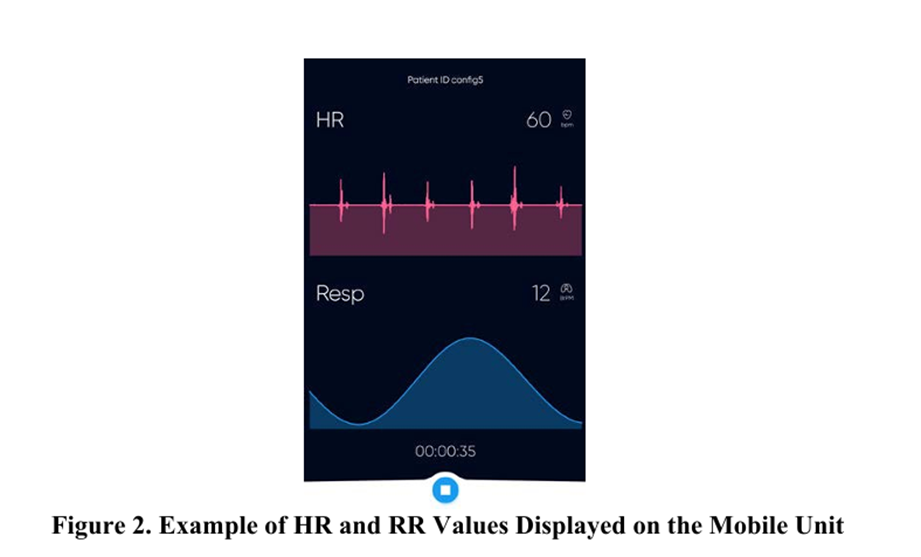

3. Cardio-TriTest v6.5 de Cardio-Phoenix Inc

El dispositivo Cardio-TriTest™ (CTT) es un aparato médico no invasivo que recoge 3 tipos diferentes de bioseñales cardíacas y las combina para crear un dispositivo más eficaz capaz de detectar y diagnosticar una gama mucho más amplia y extensa de enfermedades cardíacas comunes que el dispositivo de última generación, el ECG, utilizado actualmente en Atención Primaria. Incluye el ECG estándar de alta resolución de 12 derivaciones, un fonocardiógrafo de 4 derivaciones (PCG) y un miocardiógrafo de 4 derivaciones (MCG).  La naturaleza de las bioseñales caracteriza los aspectos eléctricos, acústicos y fisiológicos del corazón, que son complementarios y juntos proporcionan una capacidad de diagnóstico más completa del estado cardíaco [5].

Cuando se combina con el Cardio-HART™, o "CHART" para abreviar, un sistema de diagnóstico y análisis basado en la nube, basado en IA, también de Cardio-Phoenix, puede diagnosticar el 95%, en comparación con el 44% del ECG, de todas las enfermedades cardíacas comunes, por prevalencia, en Atención Primaria [5].

Estos 3 dispositivos expuestos realizan adquisición de señales por medio de diferentes métodos, por lo que es necesario un manejo adecuado de la señal y su caracterización; los dispositivos fueron sometidos a pruebas clínica para confirmar su buen funcionamiento y están aprobados por la FDA para su uso. Igualmente, se debe resaltar que en todos debe realizarse un preprocesamiento de la señal, incluyendo detección de artefactos y ruidos a ser filtrados.

Por otro lado, al hacer uso de herramientas como la IA debieron haber tenido en cuenta la arquitectura y los parámetros e hiperparámetros de interés para entrenar correctamente a los sistemas correspondientes, ya que algunos utilizan ML mientras que otros solo DL.

## Conclusiones


*   Es de gran importancia la correcta elección de hiperparámetros para definir un modelo con redes neuronales teniendo en cuenta el tipo de información que se ingresa y lo que se busca, sin embargo no es excluyente a que diferentes combinaciones pueden dar un resultado similar, todo radica en lo que se desee realizar y la prioridad que se dé a ciertos resultados.
*   La cantidad de datos para el entrenamiento del modelo cambia representativamente los resultados pues si hay los suficientes hay mejora en la precisión. Adicionalmente, se busca que no se sesge ni que hagan falta para poder realizar una clasificación óptima.  
* Es importante que las características que se emplean en los modelos y algoritmos sean lo bastante informativas para que a la hora de entrenarlos sean las más adecuadas para distinguir entre clases.


## Referencias

---




[1] J. Zheng et al., “Optimal Multi-Stage Arrhythmia Classification Approach”, Scientific Rep., vol. 10, n.º 1, febrero de 2020. Accedido el 28 de noviembre de 2024. [En línea]. Disponible: https://doi.org/10.1038/s41598-020-59821-7     

[2] Points, K. (s/f). Electrocardiogram 3: cardiac rhythm and conduction abnormalities. Emap.com. Recuperado el 29 de noviembre de 2024, de https://cdn.ps.emap.com/wp-content/uploads/sites/3/2021/07/210728-Electrocardiogram-3-cardiac-rhythm-and-conduction-abnormalities1.pdf   

[3] Tateno, K. (S/f). A Method for Detection of Atrial Fribrillation Using RR Intervals. Mcgill.ca. Recuperado el 29 de noviembre de 2024, de https://www.medicine.mcgill.ca/physio/glasslab/pub_pdf/method_2001.pdf

[4] “Atrial fibrillation: ECG, classification, causes, risk factors & management”, Cardiovascular Education.  [En línea]. Disponible en: https://ecgwaves.com/topic/atrial-fibrillation-ecg-ekg-causes-classification-management/

[5] 	E. Burns, R. Buttner, y E. B. and R. Buttner, “Atrial Fibrillation”, Life in the Fast Lane • LITFL.  [En línea]. Disponible en: https://litfl.com/atrial-fibrillation-ecg-library/

[6] Y. Hafeez y S. A. Grossman, “Sinus Bradycardia”, en StatPearls, Treasure Island (FL): StatPearls Publishing, 2024. [En línea]. Disponible en: http://www.ncbi.nlm.nih.gov/books/NBK493201/   


---

Referencias Equipos comerciales

[1] “Apple_Watch_Arrhythmia_Detection.pdf”. Consultado: el 29 de noviembre de 2024. [En línea]. Disponible en: https://www.apple.com/healthcare/docs/site/Apple_Watch_Arrhythmia_Detection.pdf

[2] 	C. for D. and R. Health, “Artificial Intelligence and Machine Learning (AI/ML)-Enabled Medical Devices”, FDA, jul. 2024, Consultado: el 29 de noviembre de 2024. [En línea]. Disponible en: https://www.fda.gov/medical-devices/software-medical-device-samd/artificial-intelligence-and-machine-learning-aiml-enabled-medical-devices

[3]	“DEN200038.pdf”. Consultado: el 29 de noviembre de 2024. [En línea]. Disponible en: https://www.accessdata.fda.gov/cdrh_docs/reviews/DEN200038.pdf

[4]	“Device Classification Under Section 513(f)(2)(De Novo)”. Consultado: el 29 de noviembre de 2024. [En línea]. Disponible en: https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfpmn/denovo.cfm?id=DEN200038

[5]	“AI innovations in primary care”. Consultado: el 30 de noviembre de 2024. [En línea]. Disponible en: https://www.cardiophoenix.com/blog/ai-innovations-in-primary-care   

   

---
Referencias Punto 8   

[1] Sanz, F. (2020, noviembre 26). Algoritmo K-Means Clustering – aplicaciones y desventajas. The Machine Learners. https://www.themachinelearners.com/k-means/   

[2] Rodríguez, D. (2023, junio 9). Método del codo (Elbow method) para seleccionar el número óptimo de clústeres en K-means. Analytics Lane. https://www.analyticslane.com/2023/06/09/metodo-del-codo-elbow-method-para-seleccionar-el-numero-optimo-de-clusteres-en-k-means/   

[3] SPSS Modeler Subscription. (2021, agosto 17). Ibm.com. https://www.ibm.com/docs/es/spss-modeler/saas?topic=mining-oracle-support-vector-machine-svm

